In [75]:
import os
import sys
import itertools
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import Bio.PDB.Polypeptide as pp
sys.path.append('/Users/macbook/Documents/GitHub/perturbation-networks-get-data')
from getmutations import MutationsDict, GetMutations
from collections import Counter
%matplotlib inline

In [2]:
AA = list(pp.aa1)

In [3]:
path = "/Users/macbook/Documents/perturbation-networks/dms_data/raw_data"
protein_path = "/Users/macbook/Documents/perturbation-networks/proteins"

In [77]:
pd.set_option('display.max_columns', None)
mpl.style.use('classic')
mpl.rcParams['grid.color'] = 'g'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'xkcd:white'

In [5]:
def PlotHeatmap(dataframe, save_as=None, vmin=None, vmax=None):
    """Plot heatmap of dataframe values.
    
    Parameters:
        dataframe: data to plot
        save_as: name of file to save. If None, image is not saved
        vmin, vmax: min and max values for colorscale
    """
    # Set missing values gray 
    sns.set(rc={'axes.facecolor':'94A3A8'})
    # Set size to match dataframe dimensions
    w = len(dataframe.columns)
    h = len(dataframe.index)
    ratio = w//h
    plt.figure(figsize=(10*ratio,10))
    heatmap = sns.heatmap(dataframe, cmap='RdBu_r', center=0, cbar=True, square=True, vmin=vmin, vmax=vmax)
    if save_as:
        fig = heatmap.get_figure()
        fig.savefig(f'{save_as}.png')
    return

## Deep Mutational Scanning Data

Processing different formats of deep mutational scanning data into DataFrames, with columns being positions, index being aminoacids.

### 1be9

In [6]:
# Positions from PDB file 
pdb_file = os.path.join(protein_path, '1be9/1be9.pdb')
mutations = MutationsDict(pdb_file, positions=[('A', 311, 393)])
mutations = [mutation[0]+mutation[2:] for mutation in mutations.keys()]

In [7]:
functional_1be9 = pd.read_csv(os.path.join(path, "1be9_functional.csv"), names=mutations)
functional_1be9.index = AA

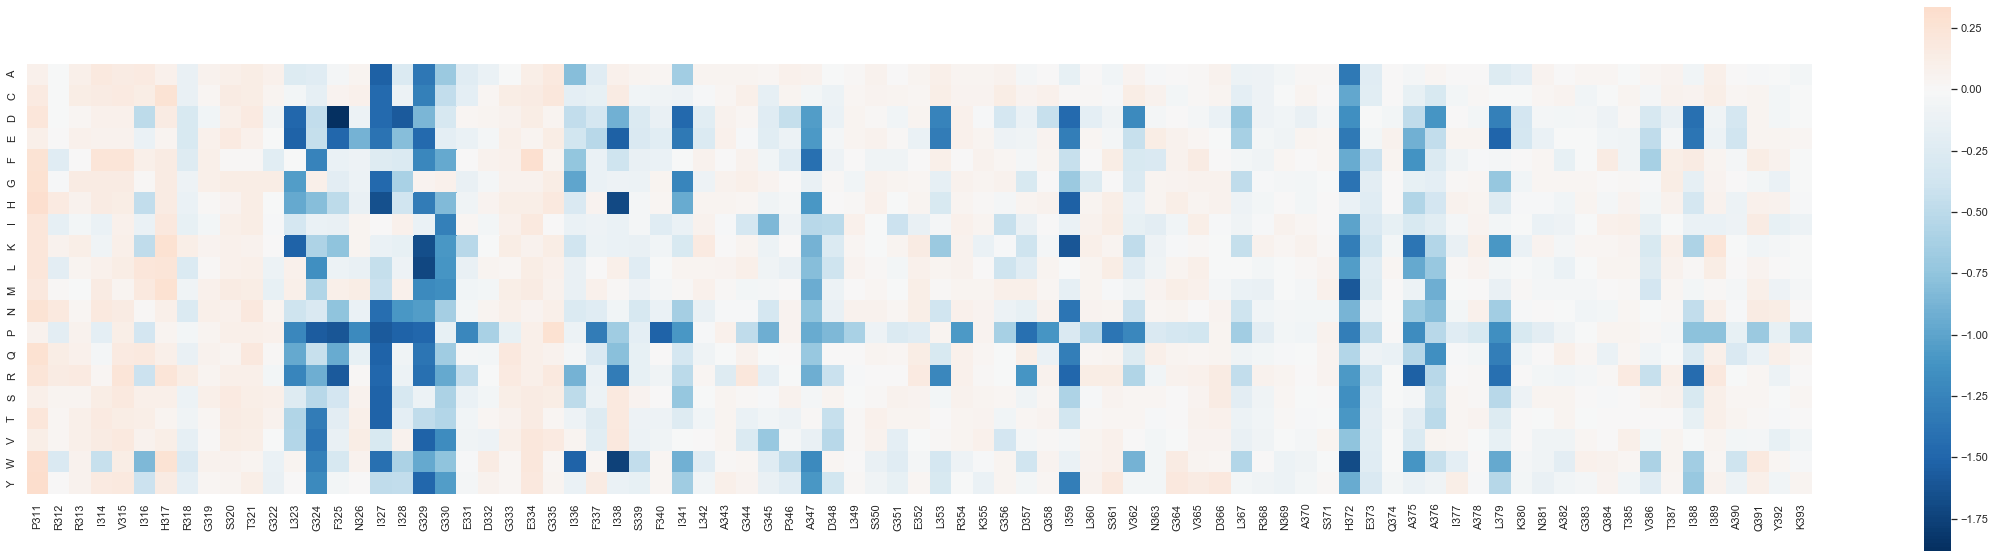

In [8]:
PlotHeatmap(functional_1be9)

### 1d5r

In [9]:
file = os.path.join(path, "1d5r_functional.csv")
funct_1d5r = pd.read_csv(file, header=0, index_col=0, usecols=[0, 6, 8, 10])

In [10]:
# Use index to get position list 
positions = []
index_list = list(funct_1d5r.index)
for index in index_list:
    #index has format A#A
    position = index[:-1]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons, '~' for deletions
#AAstop = AA + ['*', '~']
functional_1d5r = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [11]:
# If high confidence, we keep the cum_score, else, we keep imputed_score
for index, row in funct_1d5r.iterrows():
    original = index[:-1]
    mutation = index[-1]
    if mutation.isalpha():
        if row[1] == 'VERDADERO':
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Cum_score']
        else:
            functional_1d5r.at[mutation, original] = funct_1d5r.at[index, 'Imputed_Score']

In [12]:
# Only keep positions for which we also have pdb data
pdb_file = os.path.join(protein_path, '1d5r/1d5r.pdb')
mutations = list(MutationsDict(pdb_file).keys())
mutations = [mutation[0]+mutation[2:] for mutation in mutations] # remove chain id 
new_positions = [prefix for prefix in positions if prefix in mutations]
functional_1d5r = functional_1d5r[new_positions]

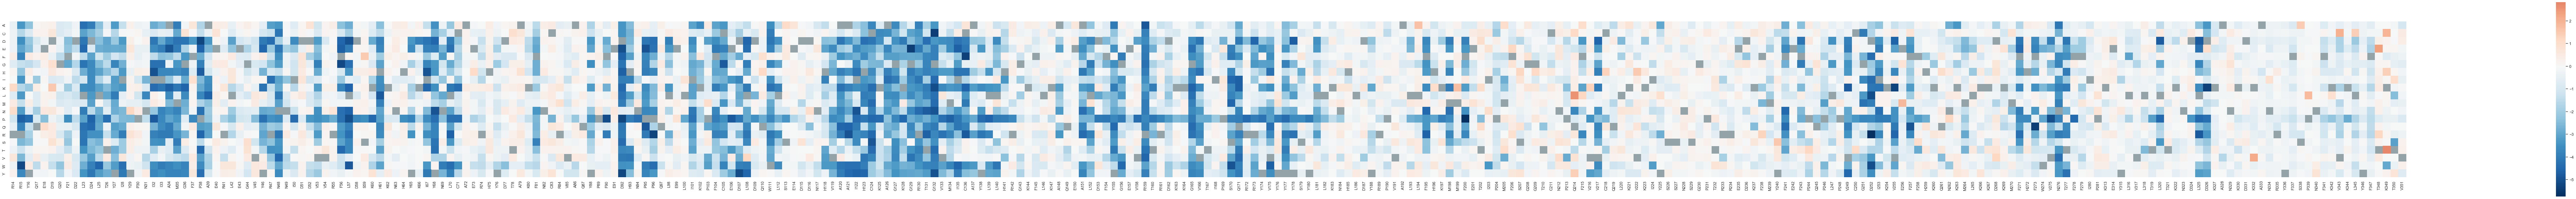

In [13]:
PlotHeatmap(functional_1d5r)

### 3dqw

In [14]:
funct_3dqw = pd.read_csv(os.path.join(path, "3dqw-functional.csv"), index_col=0)
funct_3dqw = funct_3dqw[['Scores']]

In [15]:
# Functional scores are the negative of the scores in the file 
funct_3dqw['Scores'] = funct_3dqw['Scores'].apply(lambda x:-x)

In [16]:
# Use index to get position list 
positions = []
index_list = list(funct_3dqw.index)
for index in index_list:
    # Index has format p.AAA#AAA
    original = pp.three_to_one(index[2:5].upper())
    position = original+index[5:-3]
    positions.append(position)
# Remove duplicates and sort according to position number
positions = list(set(positions))
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_3dqw = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [17]:
for index, row in funct_3dqw.iterrows():
    #index has format p.AAA#AAA
    original = index[2:5].upper()
    mutation = index[-3:].upper()
    if pp.is_aa(mutation):
        original = pp.three_to_one(original)
        mutation = pp.three_to_one(mutation)
        position = original+index[5:-3]
        functional_3dqw.at[mutation, position] = row['Scores']
    #else:
    #    original = pp.three_to_one(original)
    #    position = original+index[5:-3]
    #    functional_3dqw.at['*', position] = row['Scores']

In [18]:
# After checking both types of data, we found that the numbering of positions does not match, we adjust the numbering 
# to match PDB file, subtracting 3 from each position
aligned_positions = [position[0]+str(int(position[1:])-3) for position in positions]
functional_3dqw.columns = aligned_positions

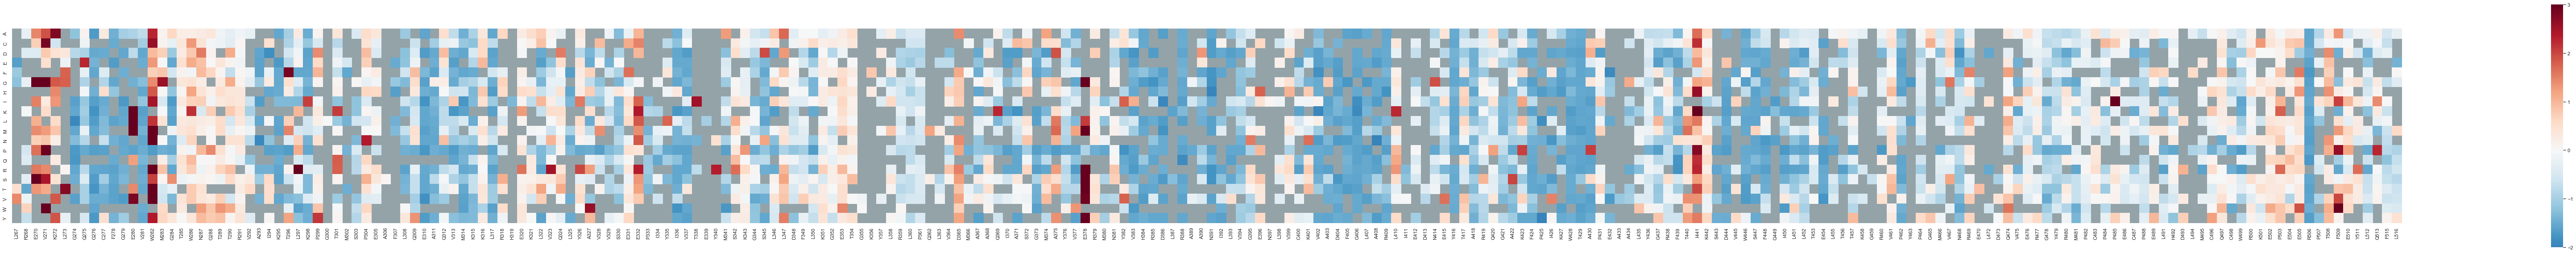

In [19]:
PlotHeatmap(functional_3dqw, vmin=-2, vmax=3)

### 4bz3

In [20]:
file = os.path.join(path, "4bz3_functional.csv")
# We are keeping selection with 128ug/mL AMP at 37C
funct_4bz3 = pd.read_csv(file, header=0, usecols=[1,2,3,12]) 

In [21]:
# Use wt residue and position to get position list 
positions = set()
for index, row in funct_4bz3.iterrows():
    positions.add(row[0]+str(row[1]))
positions = list(positions)
# Sort according to position number
positions.sort(key = lambda x:int(x[1:]))
# AA list with '*' for stop codons
#AAstop = AA + ['*']
functional_4bz3 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [22]:
for index, row in funct_4bz3.iterrows():
    original = row['wt residue']+str(row['position'])
    mutation = row['variant residue']
    if mutation.isalpha():
        functional_4bz3.at[mutation, original] = funct_4bz3.at[index, '128ug/mL_AMP_37C']

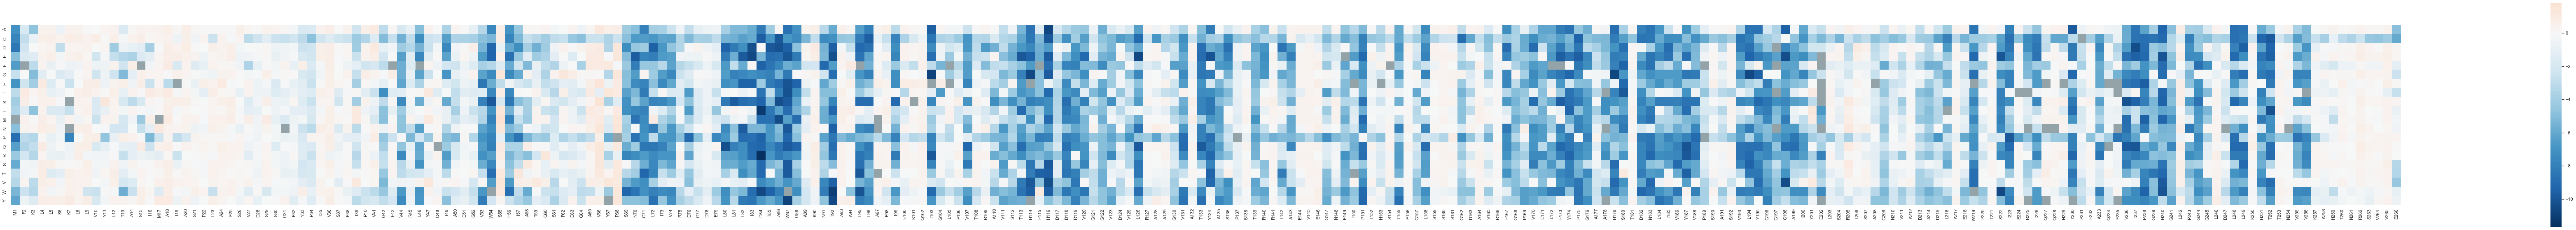

In [23]:
PlotHeatmap(functional_4bz3) #vmin=-4, vmax=4)

### 1nd4

In [24]:
def GetDataFrame(file):
    """Get dataframe and fix format issues."""
    df = pd.read_csv(file, sep='\t', skiprows=(0), lineterminator='\n', header = [1,2], index_col = [0])
    df.columns = pd.MultiIndex.from_tuples([(int(ix[0]), ix[1].rstrip()) for ix in df.columns.tolist()])
    return df
# mi yo del pasado escribió eso, no recuerdo por qué necesitaba todo eso para que sirviera, pero es por el formato de 
# los txt

In [25]:
file = os.path.join(path, "1nd4-functional/KKA2_S1_Kan12_L1.aadiff.txt")
# We are keeping selection with 1:2 kanamycin
funct_1nd4 = GetDataFrame(file) 
funct_1nd4 = funct_1nd4.drop(funct_1nd4.index[range(20,40)])

In [26]:
funct_1nd4.at['Delta-G', (1, 'M')] = np.NaN # Removing outlier value of 72202

In [27]:
# Use header to get position list 
positions = [col[1]+str(col[0]) for col in funct_1nd4.columns]
# AA list as index
functional_1nd4 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)

In [28]:
for index in funct_1nd4.index:
    for col in funct_1nd4.columns:
        position = col[1]+str(col[0])
        mutation = index[-1]
        value = funct_1nd4.at[index, col]
        functional_1nd4.at[mutation, position] = np.log10(value) #np.log2(value) #

In [29]:
log2_1nd4 = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
for index in funct_1nd4.index:
    for col in funct_1nd4.columns:
        position = col[1]+str(col[0])
        mutation = index[-1]
        value = funct_1nd4.at[index, col]
        log2_1nd4.at[mutation, position] = np.log2(value)

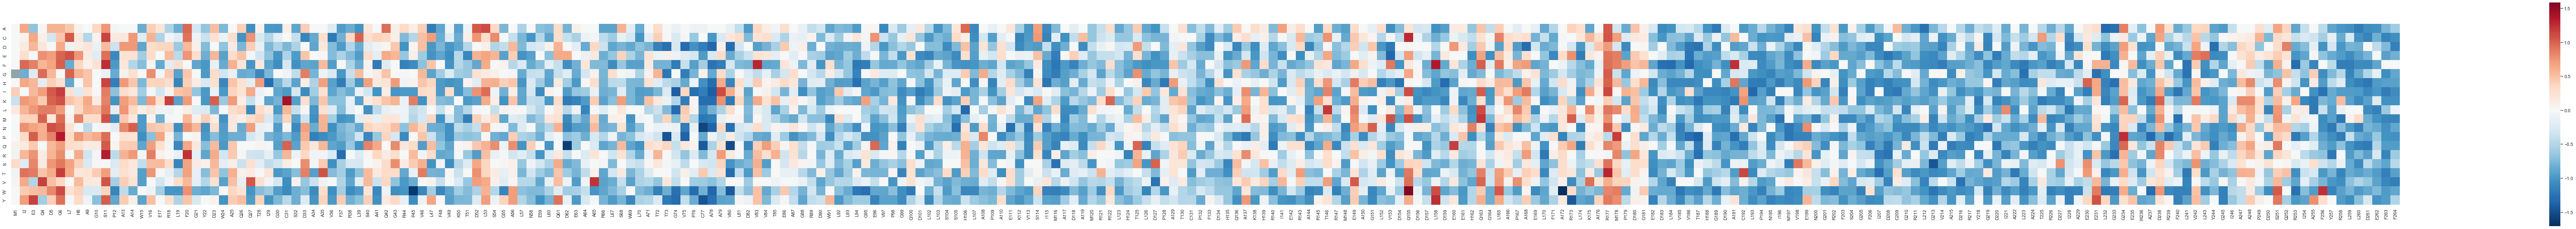

In [30]:
PlotHeatmap(functional_1nd4)

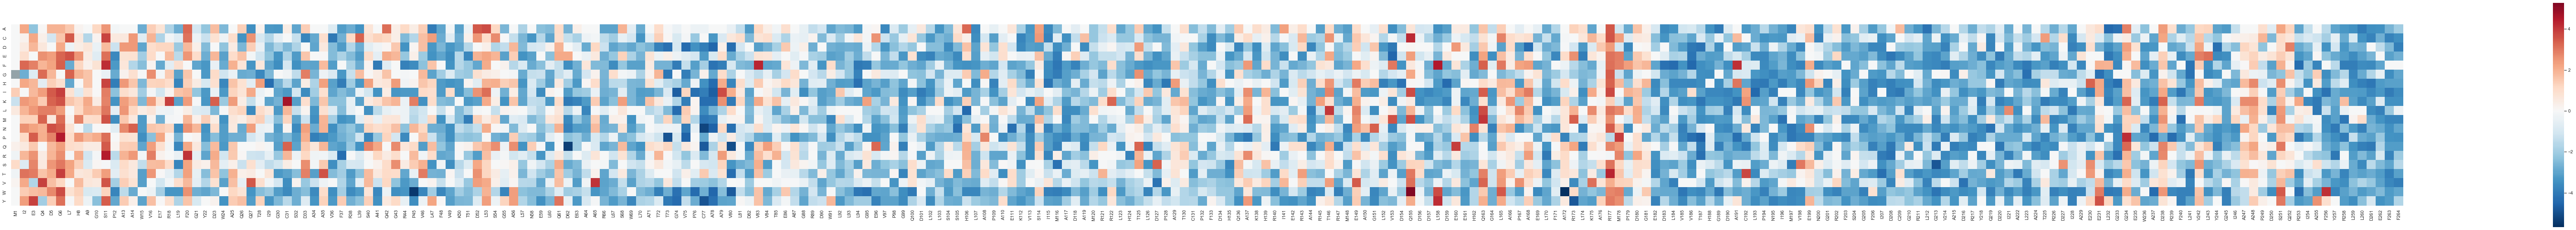

In [31]:
PlotHeatmap(log2_1nd4)

## Perturbation Network Data

In [32]:
data_path = os.path.join(protein_path, 'data')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]
measures = ['nodes', 'edges', 'weight', 'distance']
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
functional_data = {'1be9':functional_1be9, '1nd4':functional_1nd4, '1d5r':functional_1d5r, '3dqw':functional_3dqw, 
                  '4bz3':functional_4bz3}

First, fix functional DataFrames so they only have positions for which both functional and network data is available.

In [33]:
def CheckData(protein):
    """Returns list of positions (without chain id) in protein for which both DMS and network data is available."""
    functional_columns = set(functional_data[protein].columns)
    # Sample network file
    file = os.path.join(data_path, f'{protein}/{protein}_3.0_weight.csv')
    df = pd.read_csv(file, header=0)
    df_columns = list(df.columns)
    # Since network data has chain id, we need a set of positions without it
    network_columns = set([column[0]+column[2:] for column in df_columns])
    positions = list(network_columns.intersection(functional_columns))
    positions.sort(key = lambda x:int(x[1:]))
    return positions

In [34]:
len(CheckData('1be9'))

83

In [35]:
for protein in proteins:
    file = os.path.join(data_path, f'{protein}/{protein}_3.0_weight.csv')
    df = pd.read_csv(file, header=0)
    df_columns = list(df.columns)
    network_columns = set([column[1] for column in df_columns])
    print(protein, network_columns)

1be9 {'A', 'B'}
1d5r {'A'}
1nd4 {'A', 'B'}
3dqw {'D', 'A', 'B', 'C'}
4bz3 {'A', 'B'}


In [36]:
# Remove columns without both kinds of data
for protein in proteins:
    positions = CheckData(protein)
    df = functional_data[protein]
    df = df[positions]
    # Save new data in dictionary again
    functional_data[protein] = df
    
# Rewrite functional_protein dataframes 
functional_1be9 = functional_data['1be9']
functional_1nd4 = functional_data['1nd4']
functional_1d5r = functional_data['1d5r']
functional_3dqw = functional_data['3dqw']
functional_4bz3 = functional_data['4bz3']

In [37]:
def AverageOverChains(protein, threshold, measure):
    """If protein has multiple identical chains, return DataFrame with average values per position. Returns df without
    chain names in columns. """
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    df = pd.read_csv(file, header=0)
    df.index = AA
    # Get how many chains from column names 
    column_names = list(df.columns)
    chains = list(set([position[1] for position in column_names]))
    # Get positions without chain distinction, from modified functional files
    positions = list(functional_data[protein].columns)
    #positions = list(set([c[0]+c[2:] for c in column_names]))
    #positions.sort(key = lambda x:int(x[1:]))
    average = pd.DataFrame(index=AA, columns=positions, dtype=np.float64)
    # Save data for position over chains in list, write average into df
    for position in positions:
        for aa in AA:
            values = []
            for chain in chains:
                check = position[0]+chain+position[1:]
                if check in df.columns:
                    values.append(df.at[aa, check])
            if values:
                average_value = sum(values)/len(values)
                average.at[aa, position] = average_value
    return average

In [38]:
def ReadNetworkCSV(protein, threshold, measure, average=True):
    """Return DataFrame from corresponding CSV. If average, apply AverageOverChains and only show mutations for which 
    both kinds data is available."""
    file = os.path.join(data_path, f"{protein}/{protein}_{threshold}_{measure}.csv")
    # Check that file has same columns as functional
    if average:
        functional = functional_data[protein]
        df = AverageOverChains(protein, threshold, measure)
        positions = list(functional.columns)
        df = df[positions]
    else:
        df = pd.read_csv(file, header=0)
    df.index = AA
    return df

In [40]:
def SampleSpearmanR(protein, average=True, data=functional_data, thresholds=sample_thresholds, max_=False):
    """Return DataFrame with Spearman correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    functional_df = data[protein]
    functional = list(functional_df.mean())
    spearman = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            if max_:
                compare = list(df.max())
            else:
                compare = list(df.mean())
            spearman.at[threshold, measure] = round(sp.stats.spearmanr(functional, compare)[0], 3)
    spearman.loc['Mean'] = spearman.mean()
    return spearman

In [41]:
def SamplePearsonR(protein, average=True, data=functional_data, thresholds=sample_thresholds):
    """Return DataFrame with Pearson correlation coefficient between functional and network data for mean score 
    over aminoacids."""
    functional_df = data[protein]
    functional = list(functional_df.mean())
    pearson = pd.DataFrame(index=thresholds, columns=measures)
    for measure in measures:
        for threshold in thresholds:
            df = ReadNetworkCSV(protein, threshold, measure, average=average)
            compare = list(df.mean())
            pearson.at[threshold, measure] = round(sp.stats.pearsonr(functional, compare)[0], 3)
    pearson.loc['Mean'] = pearson.mean()
    return pearson

In [42]:
SampleSpearmanR('4bz3')

,nodes,edges,weight,distance
3.0,-0.312,-0.344,-0.393,-0.376
4.0,-0.601,-0.594,-0.596,-0.348
5.0,-0.626,-0.588,-0.559,-0.281
6.0,-0.689,-0.588,-0.541,-0.277
7.0,-0.647,-0.562,-0.558,-0.348
8.0,-0.681,-0.575,-0.589,-0.217
9.0,-0.713,-0.59,-0.608,-0.161
10.0,-0.687,-0.585,-0.61,-0.226
Mean,-0.6195,-0.55325,-0.55675,-0.27925


In [43]:
SamplePearsonR('1nd4')

KeyboardInterrupt: 

Las primeras correlaciones, con los promedios por posición y tomando solo una muestra de thresholds sugieren que al distancia no es tan buena medida como las otras tres, pero es interesante que varía bastante. También destaca que 3.0 da puntajes mucho más bajos que los otros thresholds de muestra, y que tres proteínas tienen valores más altos (alrededor de 0.62), mientras que las otras dos tienen valores más bajos. Para 3dqw, podría ser que faltan algunos valores de datos funcionales. 

In [44]:
# Average correlations for all sample thresholds
correlations = ['Spearman', 'Pearson']
multi_index = [x for x in itertools.product(correlations, measures)]
sample_correlations = pd.DataFrame(columns=pd.MultiIndex.from_tuples(multi_index))
for protein in proteins:
    line = list(SampleSpearmanR(protein).loc['Mean'])+list(SamplePearsonR(protein).loc['Mean'])
    sample_correlations.loc[protein] = line
display(sample_correlations)

Spearman                                 Pearson                      \
         nodes     edges    weight  distance     nodes     edges    weight   
1be9 -0.428250 -0.483375 -0.455625 -0.225750 -0.364625 -0.446625 -0.406250   
1d5r -0.622000 -0.600750 -0.569625 -0.376000 -0.647250 -0.628125 -0.570750   
1nd4 -0.642000 -0.616125 -0.590500 -0.453625 -0.573500 -0.541875 -0.504750   
3dqw -0.400875 -0.370375 -0.332500 -0.183000 -0.341125 -0.329500 -0.291625   
4bz3 -0.619500 -0.553250 -0.556750 -0.279250 -0.620625 -0.548500 -0.516250   

                
      distance  
1be9 -0.116750  
1d5r -0.342375  
1nd4 -0.431500  
3dqw -0.132250  
4bz3 -0.247750

In [45]:
# Average correlations for sample thresholds without 3.0
correlations = ['Spearman', 'Pearson']
multi_index = [x for x in itertools.product(correlations, measures)]
sample_correlations = pd.DataFrame(columns=pd.MultiIndex.from_tuples(multi_index))
for protein in proteins:
    new_thresholds = [i for i in np.linspace(4, 10, 7)]
    line = list(SampleSpearmanR(protein, thresholds=new_thresholds).loc['Mean']) +\
            list(SamplePearsonR(protein, thresholds=new_thresholds).loc['Mean'])
    sample_correlations.loc[protein] = line
display(sample_correlations)

Spearman                                 Pearson                      \
         nodes     edges    weight  distance     nodes     edges    weight   
1be9 -0.468143 -0.523714 -0.491000 -0.238571 -0.388143 -0.474857 -0.421857   
1d5r -0.657000 -0.632143 -0.598000 -0.381286 -0.681143 -0.658286 -0.595286   
1nd4 -0.663714 -0.634143 -0.603857 -0.455143 -0.589714 -0.556143 -0.520143   
3dqw -0.431000 -0.398571 -0.352714 -0.188000 -0.368857 -0.355143 -0.304714   
4bz3 -0.663429 -0.583143 -0.580143 -0.265429 -0.660857 -0.573429 -0.535286   

                
      distance  
1be9 -0.112143  
1d5r -0.342714  
1nd4 -0.428714  
3dqw -0.132571  
4bz3 -0.238571

In [46]:
# Only keep positions for 3dqw for which there's data of at least 15 mutations
# Positions reduced from 242 to 129
filtered_3dqw = functional_3dqw.copy()
filtered_3dqw = filtered_3dqw.dropna(axis=1, thresh=15)# Remove columns with less than 15 non NaN values.
positions = list(filtered_3dqw.columns)
# Run Pearson and Spearman for sample thresholds to compare 
filtered_spearman = pd.DataFrame(index=sample_thresholds, columns=measures)
filtered_pearson = pd.DataFrame(index=sample_thresholds, columns=measures)
for measure in measures:
    for threshold in sample_thresholds:
        df = ReadNetworkCSV('3dqw', threshold, measure)
        df = df[positions]
        network_mean = list(df.mean())
        filtered_mean = list(filtered_3dqw.mean())
        filtered_pearson.at[threshold, measure] = round(sp.stats.pearsonr(network_mean, filtered_mean)[0], 3)
        filtered_spearman.at[threshold, measure] = round(sp.stats.spearmanr(network_mean, filtered_mean)[0], 3)
filtered_pearson.loc['Mean'] = filtered_pearson.mean()
filtered_spearman.loc['Mean'] = filtered_spearman.mean()
display(filtered_spearman)

,nodes,edges,weight,distance
3.0,-0.235,-0.217,-0.243,-0.173
4.0,-0.405,-0.403,-0.337,-0.264
5.0,-0.415,-0.412,-0.348,-0.258
6.0,-0.457,-0.434,-0.39,-0.267
7.0,-0.498,-0.465,-0.409,-0.217
8.0,-0.493,-0.458,-0.435,-0.256
9.0,-0.512,-0.465,-0.445,-0.27
10.0,-0.514,-0.476,-0.466,-0.26
Mean,-0.441125,-0.41625,-0.384125,-0.245625


Mejora un poco, pero no sé si sea exactamente eso lo que nos está dando valores bajos, al menos en ese caso. Probaremos ahora correlaciones por columna, primero solo para threshold = 5.0. 

In [47]:
def SpearmanByColumn(protein, threshold=5.0, data=functional_data):
    """Returns DataFrame with Spearman correlation value for each column in protein. """
    functional_df = data[protein]
    positions = list(functional_df.columns)
    by_column = pd.DataFrame(index=measures, columns=positions)
    for measure in measures:
        network_df = ReadNetworkCSV(protein, threshold, measure)
        for position in positions:
            network_column = list(network_df[position])
            functional_column = list(functional_df[position])
            by_column.at[measure, position] = round(sp.stats.spearmanr(network_column, functional_column, 
                                                                        nan_policy='omit')[0], 3)
    return by_column

In [48]:
SpearmanByColumn('1d5r')

,R14,R15,Y16,Q17,E18,D19,G20,F21,D22,L23,D24,L25,T26,Y27,I28,Y29,P30,N31,I32,I33,A34,M35,G36,F37,P38,A39,E40,R41,L42,E43,G44,V45,Y46,R47,N48,N49,I50,D51,D52,V53,V54,R55,F56,L57,D58,S59,K60,H61,K62,N63,H64,Y65,K66,I67,Y68,N69,L70,C71,A72,E73,R74,H75,Y76,D77,T78,A79,K80,F81,N82,C83,R84,V85,A86,Q87,Y88,P89,F90,E91,D92,H93,N94,P95,P96,Q97,L98,E99,L100,I101,K102,P103,F104,C105,E106,D107,L108,D109,Q110,W111,L112,S113,E114,D115,D116,N117,H118,V119,A120,A121,I122,H123,C124,K125,A126,G127,K128,G129,R130,T131,G132,V133,M134,I135,C136,A137,Y138,L139,L140,H141,R142,G143,K144,F145,L146,K147,A148,Q149,E150,A151,L152,D153,F154,Y155,G156,E157,V158,R159,T160,R161,D162,K163,K164,G165,V166,T167,I168,P169,S170,Q171,R172,R173,Y174,V175,Y176,Y177,Y178,S179,Y180,L181,L182,K183,N184,H185,L186,D187,Y188,R189,P190,V191,A192,L193,L194,F195,H196,K197,M198,M199,F200,E201,T202,I203,P204,M205,F206,S207,G208,G209,T210,C211,N212,P213,Q214,F215,V216,V217,C218,Q219,L220,K221,V222,K223,I224,Y225,S226,S227,N228,S229,G230,P231,T232,R233,R234,E235,D236,K237,F238,M239,Y240,F241,E242,F243,P244,Q245,P246,L247,P248,V249,C250,G251,D252,I253,K254,V255,E256,F257,F258,H259,K260,Q261,N262,K263,M264,L265,K266,K267,D268,K269,M270,F271,H272,F273,W274,V275,N276,T277,F278,F279,I280,P281,K313,E314,Y315,L316,V317,L318,T319,L320,T321,K322,N323,D324,L325,D326,K327,A328,N329,K330,D331,K332,A333,N334,R335,Y336,F337,S338,P339,N340,F341,K342,V343,K344,L345,Y346,F347,T348,K349,T350,V351
nodes,-0.208,-0.043,-0.484,0.099,-0.177,-0.132,-0.209,-0.466,0.12,-0.457,-0.628,0.079,0.075,-0.643,-0.445,0.316,-0.269,-0.032,-0.432,-0.602,-0.648,-0.177,-0.641,-0.132,-0.023,-0.487,-0.363,-0.463,-0.125,0.002,-0.426,-0.072,-0.189,0.546,0.074,-0.515,0.201,0.555,-0.251,-0.252,-0.225,-0.356,-0.058,-0.114,-0.134,0.137,-0.347,-0.042,-0.326,-0.03,-0.375,0.123,-0.409,-0.58,-0.228,-0.171,-0.306,-0.32,0.07,-0.191,0.103,-0.048,-0.127,-0.158,-0.08,-0.132,-0.146,-0.113,-0.388,-0.298,0.067,-0.149,-0.091,-0.242,-0.385,-0.169,-0.165,-0.14,0.266,-0.243,-0.12,-0.717,-0.567,-0.332,-0.059,-0.023,0.085,-0.108,0.281,-0.07,-0.322,-0.134,-0.252,-0.502,0.197,-0.062,-0.117,-0.082,-0.349,-0.315,-0.07,0.127,0.03,0.025,-0.341,-0.378,-0.626,-0.49,-0.073,-0.429,0.348,-0.116,-0.348,0.212,-0.461,-0.32,-0.047,-0.557,0.036,-0.619,-0.05,-0.337,-0.546,-0.688,0.021,-0.12,-0.522,-0.061,-0.099,-0.327,-0.335,-0.345,-0.154,-0.37,-0.118,-0.226,0.287,-0.632,-0.289,-0.265,-0.283,-0.515,-0.331,0.394,-0.053,0.021,-0.33,-0.086,-0.152,-0.023,0.137,-0.347,-0.373,0.156,-0.057,0.227,-0.11,0.062,-0.313,-0.513,-0.379,-0.702,0.62,-0.653,-0.467,-0.176,-0.13,-0.267,-0.22,0.186,-0.113,0.135,-0.124,0.044,-0.467,-0.014,0.062,0.081,0.1,-0.067,-0.031,0.363,-0.313,0.032,-0.008,-0.248,0.057,-0.521,-0.311,-0.314,0.129,-0.107,-0.063,0.136,-0.116,-0.329,-0.237,0.102,-0.204,-0.147,0.159,-0.063,0.123,-0.323,-0.209,0.175,0.289,-0.105,-0.118,0.023,-0.341,-0.514,-0.019,0.028,0.115,-0.005,0.118,-0.422,-0.231,-0.091,-0.499,0.164,0.395,0.061,0.166,0.331,0.018,0.007,0.414,-0.179,0.196,0.068,0.111,-0.053,-0.249,-0.479,0.14,-0.006,-0.586,0.231,-0.412,-0.113,0.398,0.109,-0.034,-0.161,-0.017,-0.323,0.218,-0.194,-0.146,0.013,-0.072,0.387,-0.028,0.184,0.293,0.467,0.109,0.135,-0.348,0.065,-0.104,-0.396,-0.294,-0.129,0.168,0.015,0.083,-0.435,-0.266,-0.602,0.087,-0.063,-0.244,-0.134,-0.108,-0.297,0.228,-0.087,-0.025,0.046,0.008,-0.239,-0.04,-0.093,0.009,-0.423,0.356,-0.253,-0.353,-0.391,-0.213,-0.3,-0.123,-0.072,-0.159,-0.205,-0.174,-0.082,-0.277,0.226,-0.012,-0.097,-0.101,-0.584,-0.303
edges,-0.296,-0.05,-0.538,0.123,-0.244,-0.103,-0.319,-0.404,0.072,-0.488,-0.68,0.041,-0.025,-0.661,-0.418,0.349,-0.205,-0.069,-0.477,-0.441,-0.642,-0.082,-0.577,0.024,-0.097,-0.321,-0.334,-0.463,-0.109,0.002,-0.373,-0.061,-0.166,0.571,0.121,-0.479,0.125,0.556,-0.273,-0.297,-0.229,-0.548,-0.075,-0.142,-0.257,0.024,-0.377,-0.065,-0.354,-0.032,-0.432,0.042,-0.225,-0.497,-0.287,-0.067,-0.286,-0.412,-0.018,-0.328,-0.044,-0.048,-0.253,-0.143,-0.078,-0.161,-0.116,-0.122,-0.353,-0.381,0.09,-0.138,-0.034,-0.263,-0

Las correlaciones por columnas dan valores muy variables. ¿Cuáles son los que tienen altas? ¿Nos interesa saberlo? En teoría, correlaciones altas implican que para esa posición, los cambios en la estructura de la proteína se correlacionan con los cambios funcionales. Creo que no tiene tanto significado, porque son poquitos puntos (20, menos si faltan valores), y los resultados son súper distintos, incluso dentro de la misma posición para distintas métricas. Podemos checarlo para todos los datos, sin considerar los promedios. 

Nodes parece ser la mejor métrica, vamos a graficar algunos thresholds para ver qué está pasando.

In [49]:
def PlotAverages(protein, thresholds=sample_thresholds, measure='nodes', data=functional_data):
    """Plot both kinds of data for the 8 sample thresholds. """
    functional_df = data[protein]
    functional_average = list(functional_df.mean())
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(f'Protein = {protein}')
    
    for x, threshold in enumerate(thresholds):
        network_df = ReadNetworkCSV(protein, threshold, measure)
        network_average = list(network_df.mean())
        
        ax = fig.add_subplot(2, 4, x+1)
        ax.set_facecolor('xkcd:white')
        plt.plot(functional_average, network_average, 'bo')
        plt.xlabel('Functional Data Average per Position')
        plt.ylabel(f'{measure} Data Average per Position')
        plt.title(f'Threshold = {threshold}')
    
    plt.show()
    return

In [ ]:
PlotAverages('1be9', measure='distance')

In [ ]:
PlotAverages('1nd4')

In [ ]:
PlotAverages('1d5r')

In [ ]:
PlotAverages('3dqw')

In [ ]:
PlotAverages('4bz3')

Parece que si los valores de datos funcionales están tan bien distribuidos, se ve mucho mejor correlación lineal. Por ejemplo, 4bz3 y 1nd4 son buenos, pero un valor muy alto en 3dqw parece distorcionar mucho los valores para los números bajos. 1be9 y 1d5r parecen presentar más o menos el mismo problema, donde hay muchos valores pegados al principio y eso distorciona un poco los demás valores. Si todos los papers aplican las mismas funciones para obtener los valores (creo que todos usan logaritmos, tengo que checarlo. ¿Tal vez las bases lo están distorcionando?), podríamos aplicar la misma transformación a todos los valores para que estén mejor distribuidos. 

Probemos esa hipótesis quitando los outliers de 3dqw. 

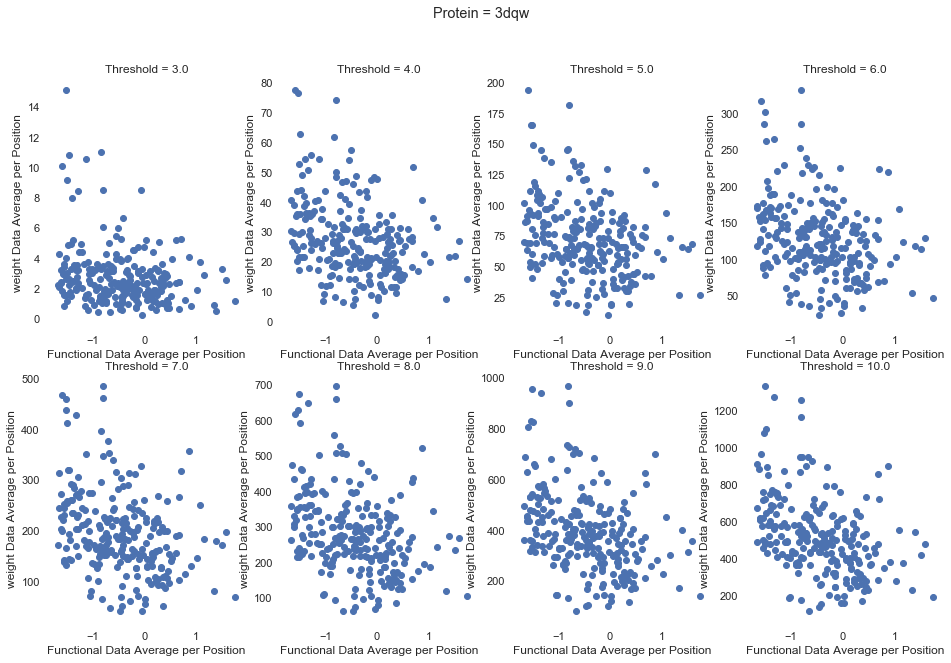

In [51]:
functional_average = list(functional_data['3dqw'].mean())
indices_to_delete = []
for i, x in enumerate(functional_average):
    if x > 2:
        indices_to_delete.append(i)
indices_to_delete.sort(reverse=True)
for i in indices_to_delete:
    del functional_average[i]
    
corr = pd.DataFrame(index=sample_thresholds, columns=['Pearson', 'Spearman'])
    
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Protein = 3dqw')
measure='weight'

for x, threshold in enumerate(sample_thresholds):
    network_df = ReadNetworkCSV('3dqw', threshold, measure)
    network_average = list(network_df.mean())
     
    for i in indices_to_delete:
        del network_average[i]
    
    corr.at[threshold, 'Pearson'] = round(sp.stats.pearsonr(functional_average, network_average)[0], 3)
    corr.at[threshold, 'Spearman'] = round(sp.stats.spearmanr(functional_average, network_average)[0], 3)
    
    ax = fig.add_subplot(2, 4, x+1)
    ax.set_facecolor('xkcd:white')
    plt.plot(functional_average, network_average, 'bo')
    plt.xlabel('Functional Data Average per Position')
    plt.ylabel(f'{measure} Data Average per Position')
    plt.title(f'Threshold = {threshold}')

In [52]:
corr

,Pearson,Spearman
3.0,-0.242,-0.211
4.0,-0.325,-0.326
5.0,-0.324,-0.321
6.0,-0.335,-0.349
7.0,-0.355,-0.372
8.0,-0.376,-0.396
9.0,-0.395,-0.42
10.0,-0.415,-0.445


Sigue sin mejorar demasiado... Es curioso que haya dos rangos de valores de correlación, y no estoy muy segura de qué hace diferentes a las dos proteínas con valores más bajos de las otras tres. 

No estoy muy segura de qué hacer sobre los valores absolutos, en los casos donde tenemos valores tanto positivos como negativos. Pensando más en el caso de 3dqw, donde aplicar valor absoluto baja un poco la correlación, es interesante que los valores con ganancia de función tienen valores más bajos en los nodos que los de pérdida de función con la misma magnitud. Supongo que la explicación biológica es que la proteína no puede mejorar demasiado cambiando su estructura, porque la estructura que ya tiene es muy buena. Eso me sugiere que es mejor trabajar con los valores normales y no los absolutos, pero en ese caso no sé qué hacer con 1be9. 

Creo que antes de seguir con las correlaciones por posición y mutación (que no sé qué tanta fe les tengo, porque las de las columnas no fueron tan ilustrativas), creo que sería interesante leer más sobre la forma de analizar los datos de las proteínas, por ejemplo, si algunas son log base 2 o base 10, y ver si eso arroja alguna diferencia clara entre las dos proteínas que tienen menor correlación. De cualquier manera creo que es claro que sí estamos obteniendo información de las gráficas. 

Tal vez sería interesante tomar las posiciones con el 10% (o 5% o algo) de valores más altos, y compararlas con las posiciones que los artículos identifican como más sensibles. Solo de ver las gráficas, parece que casi todos los valores altos corresponden a pérdidas de función significativas, lo cual tiene mucho sentido, pero que no siempre si el cambio funcional es grande, hay un cambio grande en las gráficas. Podríamos tomar los valores más altos para cada una de las métricas (weight, distance, nodes, edges), y tal vez al juntarlos eso nos dé una mejor predicción de las mutaciones sensibles (es decir, que con que una métrica sea alta, podemos decir que es sensible aunque las otras sean promedio). O, por ejemplo, ver si con que haya un aminoácido en una posición que dé valores altos en las gráficas, podemos decir que es una posición sensible aunque no necesariamente todos los aminoácidos en esa posición den valores altos. 

In [58]:
def PlotSpearman(protein, thresholds=thresholds, max_=False):
    """Plot absolute value of Spearman correlation by threshold."""
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(f'Protein = {protein}')
    values = SampleSpearmanR(protein, thresholds=thresholds, max_=max_)
    for x, measure in enumerate(measures):
        sp_values = [abs(values.at[threshold, measure]) for threshold in thresholds]
        ax = fig.add_subplot(1, 4, x+1)
        ax.set_facecolor('xkcd:white')
        ax.set_ylim([0,1])
        plt.plot(thresholds, sp_values, 'bo')
        plt.xlabel('Thresholds')
        plt.ylabel('Spearman Correlation')
        plt.title(f'Measure = {measure}')
        
    plt.show()
    return

In [62]:
values = dict()
for protein in proteins:
    values[protein] = SampleSpearmanR(protein, thresholds=thresholds)

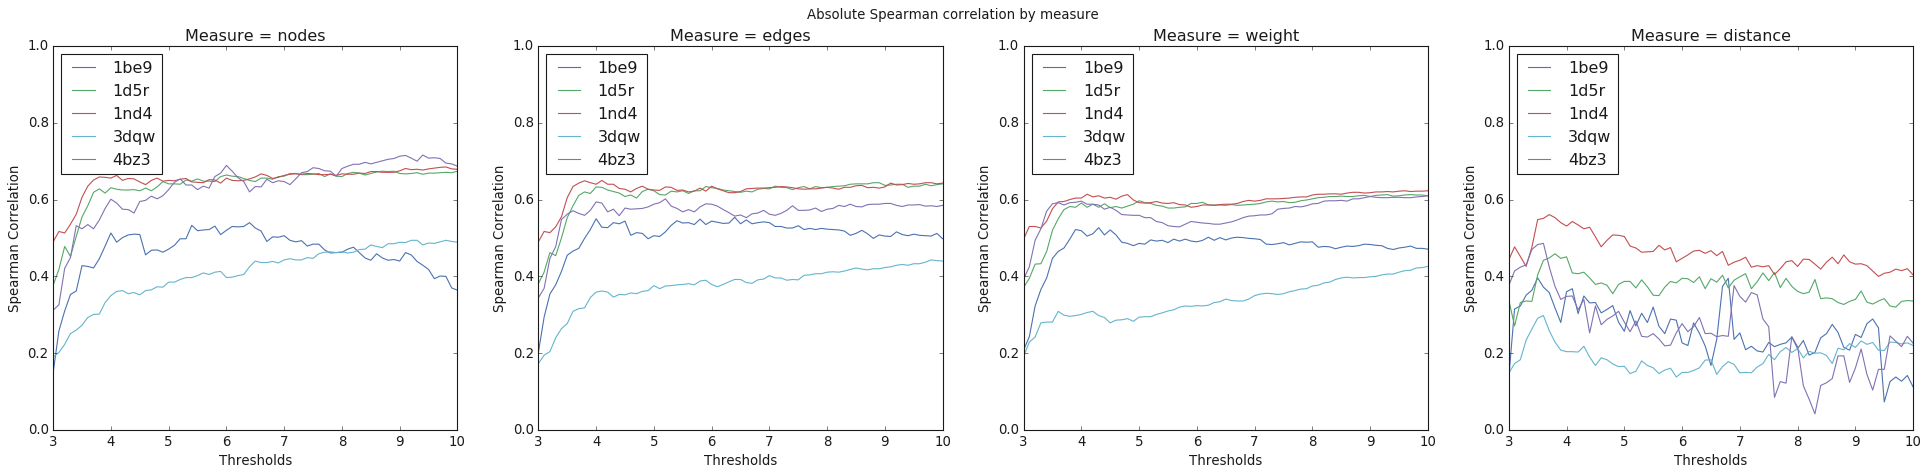

In [87]:
fig = plt.figure(figsize=(30,6))
fig.suptitle(f'Absolute Spearman correlation by measure')
for x, measure in enumerate(measures):
    ax = fig.add_subplot(1, 4, x+1)
    ax.set_facecolor('xkcd:white')
    ax.set_ylim([0,1])
    for protein in proteins:
        sp_values = [abs(values[protein].at[threshold, measure]) for threshold in thresholds]
        plt.plot(thresholds, sp_values, label=protein)
    plt.xlabel('Thresholds')
    plt.ylabel('Spearman Correlation')
    plt.title(f'Measure = {measure}')
    plt.legend(loc='upper left')

fig1 = plt.gcf()
plt.show()
fig1.savefig('correlations.jpg')

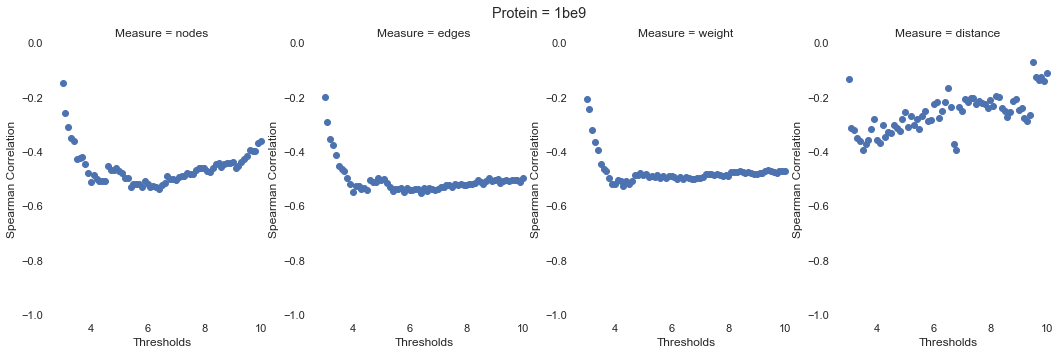

In [57]:
PlotSpearman('1be9')

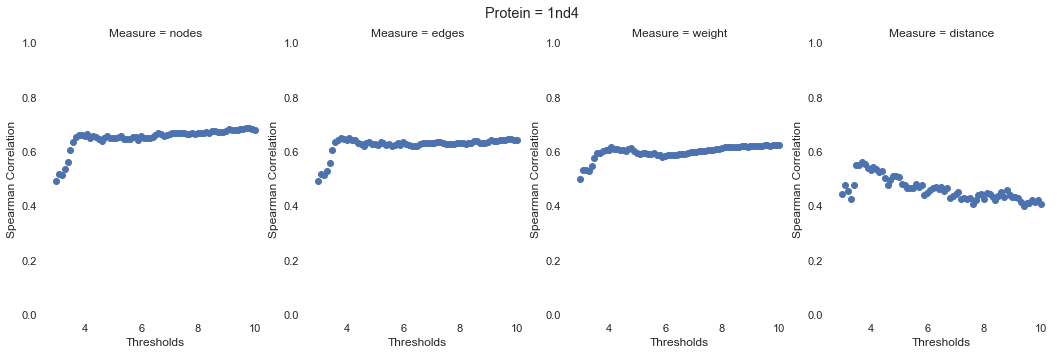

In [55]:
PlotSpearman('1nd4')

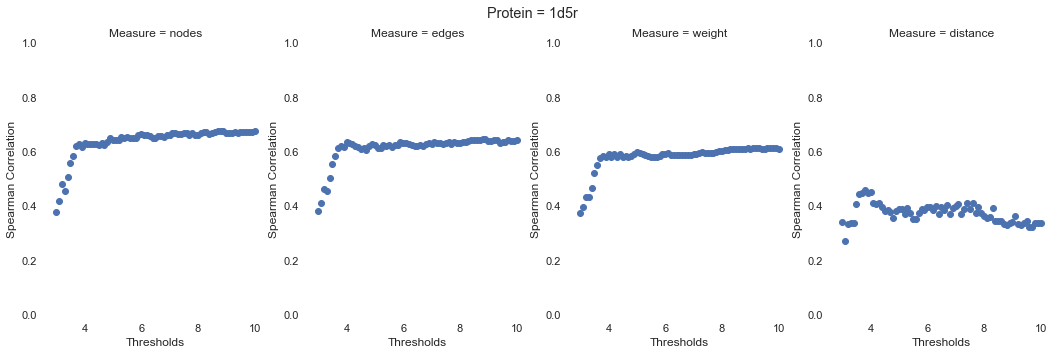

In [56]:
PlotSpearman('1d5r')

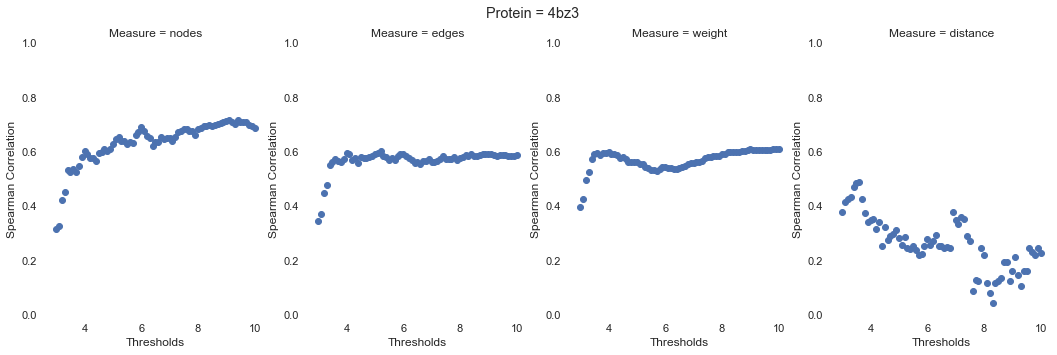

In [57]:
PlotSpearman('4bz3')

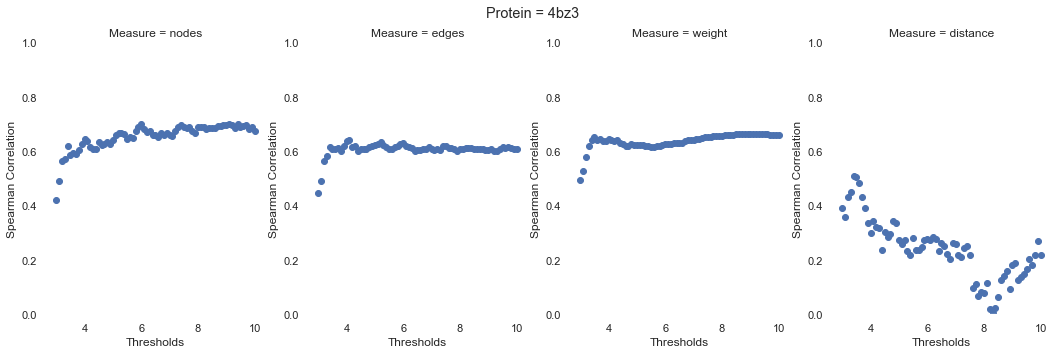

In [133]:
PlotSpearman('4bz3', max_=True)

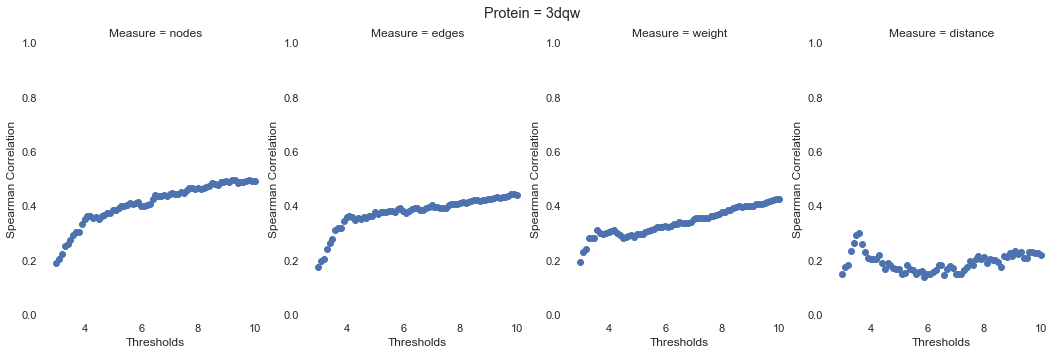

In [58]:
PlotSpearman('3dqw')

Parece que la mejor medida son los nodos. Se ve muy clara la distinción con thresholds arriba de 4.0, para algunas se mantiene al llegar ahí, y para otras sigue creciendo. Creo que 9.0 o 10.0 es un buen threshold para referencia. Es interesante cómo cambia la distancia, y que su pico es alrededor de 3.5-3.8. 

In [135]:
for protein in proteins:
    display(SampleSpearmanR(protein, thresholds = [3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 4.1]))

,nodes,edges,weight,distance
3.1,-0.258,-0.294,-0.243,-0.315
3.2,-0.31,-0.354,-0.323,-0.323
3.3,-0.353,-0.378,-0.366,-0.351
3.4,-0.362,-0.413,-0.396,-0.364
3.5,-0.428,-0.455,-0.447,-0.396
3.6,-0.426,-0.466,-0.465,-0.372
3.7,-0.422,-0.473,-0.474,-0.358
3.8,-0.446,-0.499,-0.497,-0.318
3.9,-0.479,-0.522,-0.522,-0.28
4.0,-0.513,-0.55,-0.519,-0.36


,nodes,edges,weight,distance
3.1,-0.418,-0.411,-0.395,-0.271
3.2,-0.478,-0.462,-0.432,-0.332
3.3,-0.452,-0.454,-0.433,-0.336
3.4,-0.504,-0.5,-0.465,-0.335
3.5,-0.555,-0.553,-0.52,-0.404
3.6,-0.584,-0.584,-0.55,-0.442
3.7,-0.619,-0.611,-0.574,-0.448
3.8,-0.628,-0.62,-0.582,-0.459
3.9,-0.617,-0.616,-0.58,-0.447
4.0,-0.631,-0.633,-0.591,-0.451


,nodes,edges,weight,distance
3.1,-0.517,-0.517,-0.53,-0.477
3.2,-0.513,-0.514,-0.53,-0.452
3.3,-0.536,-0.529,-0.526,-0.426
3.4,-0.562,-0.555,-0.544,-0.476
3.5,-0.606,-0.605,-0.576,-0.548
3.6,-0.635,-0.634,-0.594,-0.551
3.7,-0.651,-0.643,-0.595,-0.561
3.8,-0.659,-0.649,-0.6,-0.553
3.9,-0.658,-0.644,-0.604,-0.54
4.0,-0.656,-0.64,-0.604,-0.531


,nodes,edges,weight,distance
3.1,-0.202,-0.195,-0.229,-0.173
3.2,-0.223,-0.204,-0.242,-0.183
3.3,-0.251,-0.24,-0.279,-0.234
3.4,-0.26,-0.264,-0.281,-0.263
3.5,-0.273,-0.277,-0.281,-0.291
3.6,-0.293,-0.309,-0.309,-0.298
3.7,-0.301,-0.316,-0.299,-0.259
3.8,-0.302,-0.318,-0.296,-0.229
3.9,-0.332,-0.345,-0.298,-0.208
4.0,-0.35,-0.359,-0.301,-0.204


,nodes,edges,weight,distance
3.1,-0.326,-0.369,-0.425,-0.414
3.2,-0.421,-0.447,-0.494,-0.424
3.3,-0.449,-0.477,-0.524,-0.43
3.4,-0.532,-0.548,-0.57,-0.47
3.5,-0.524,-0.562,-0.589,-0.483
3.6,-0.535,-0.571,-0.592,-0.486
3.7,-0.524,-0.564,-0.586,-0.425
3.8,-0.547,-0.559,-0.592,-0.374
3.9,-0.577,-0.572,-0.593,-0.34
4.0,-0.601,-0.594,-0.596,-0.348


### Standardizing Data

In [60]:
# Standardize functional data, store resulting dataframes in standardized_data
standardized_data = dict()
for protein in proteins:
    data = functional_data[protein]
    data_array = data.to_numpy()
    data_mean = np.nanmean(data, dtype=np.float64)
    data_std = np.nanstd(data, dtype=np.float64)
    data = data.apply(lambda x:(x-data_mean)/data_std)
    standardized_data[protein] = data

No sé si los datos de las gráficas deberíamos normalizarlos a 0-1 o a una gaussiana, siento que el 0 debería seguir siendo 0, porque justo representa que no hay cambio. Pero en ese caso, definir las posiciones sensibles no es tan fácil como los datos funcionales (donde nos basaríamos en desviaciones estándar). En los heatmaps se ve que estandarizar con los ceros afecta la distribución de los otros valores, y para poder identificar las posiciones con cambios, hay que estandarizar sin los ceros. 

Intenté tomar solo los que tenían valores muy altos en sus redes, pero creo que algo más ilustrativo sería comparar los que están arriba del promedio en datos funcionales con los que están abajo del promedio en las redes de perturbación, y vice versa.  

Quitar los ceros no cambia las correlaciones (supongo que por ser transformación lineal?), pero creo que ayudará a identificar nuestras posiciones sensibles. Por los heatmaps, el efecto en las otras proteínas no era tanto, pero igual creo que era importante notarlo y hacer las comparaciones con estos datos. 

En ambos casos, redes y datos funcionales, creo que hace cosas algo extrañas el estandarizar con el promedio a cero, siento que importa mucho más la distancia de un valor a cero, que la distancia de un valor al cambio promedio, pero no sé cómo normalizar de forma que podamos trabajar con las desviaciones estándar pero no perder la información de estar arriba o abajo del cero (¿tal vez estandarizar sin restar la media?).

In [61]:
def RemoveZeros(protein, threshold, measure):
    df = ReadNetworkCSV(protein, threshold, measure)
    for position in df.columns:
        for aa in df.index:
            if position[0] == aa:
                df.at[aa, position] = np.nan
    return df

In [62]:
def Standardize(protein, threshold, measure, function=RemoveZeros):
    """Return standardized values from network data."""
    data = function(protein, threshold, measure)
    data_array = data.to_numpy()
    data_mean = np.nanmean(data, dtype=np.float64)
    data_std = np.nanstd(data, dtype=np.float64)
    data = data.apply(lambda x:(x-data_mean)/data_std)
    return data 

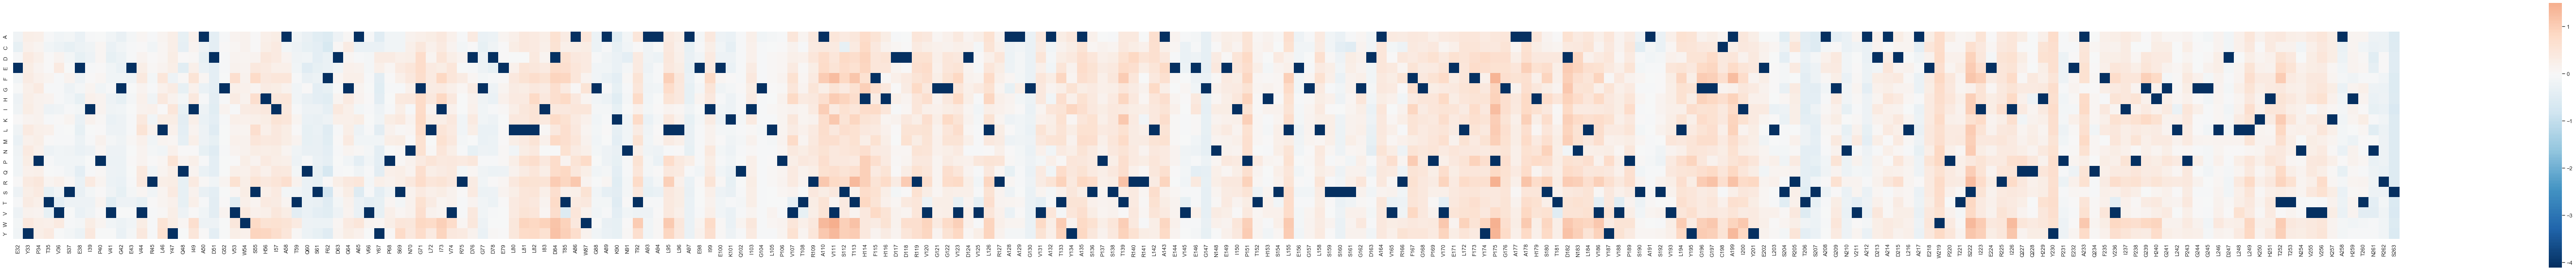

In [63]:
PlotHeatmap(Standardize('4bz3', 9.0, 'nodes', function=ReadNetworkCSV))

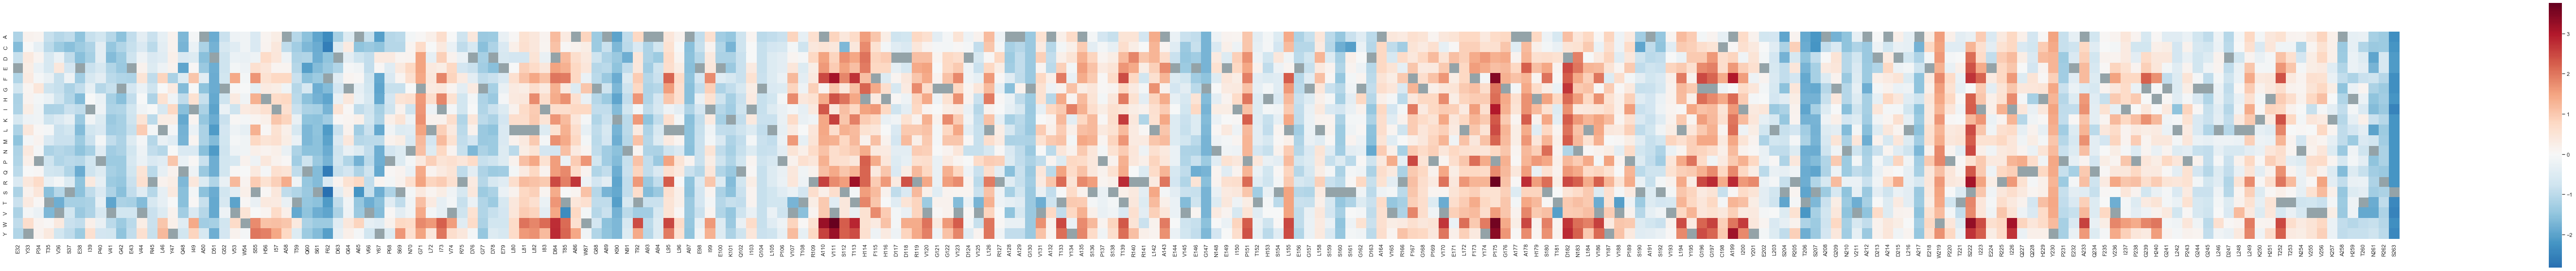

In [64]:
PlotHeatmap(Standardize('4bz3', 9.0, 'nodes'))

In [65]:
def CheckDistribution(cutoffs, proteins=proteins, data=standardized_data, absolute=False):
    """Return df with number of positions with mean above cutoffs (if positive), or below cutoffs (if negative) and 
    percentage. If absolute, check above and below."""
    columns = []
    for cutoff in cutoffs:
        columns.extend([f'{cutoff} std', f'% {cutoff} std'])
    values = pd.DataFrame(index=proteins, columns=columns)
    for protein in proteins:
        data_df = data[protein]
        data_mean = list(data_df.mean())
        n = len(data_mean)
        for cutoff in cutoffs:
            if not absolute:
                if cutoff > 0:
                    m = len([i for i in data_mean if i > cutoff])
                elif cutoff < 0:
                    m = len([i for i in data_mean if i < cutoff])
            else:
                assert cutoff > 0, 'Cutoffs should be positive'
                m = len([i for i in data_mean if i > cutoff or i < -cutoff])
            values.at[protein, f'{cutoff} std'] = m
            values.at[protein, f'% {cutoff} std'] = str(round(100*m/n, 1))+'%'
    return values

In [109]:
# Compare number of positions one and two standard deviations from mean (functional data)
display(CheckDistribution([1,2], absolute=True))
display(CheckDistribution([-2, -1, 1, 2]))

,1 std,% 1 std,2 std,% 2 std
1be9,11,13.3%,3,3.6%
1d5r,49,16.0%,2,0.7%
1nd4,26,10.2%,2,0.8%
3dqw,49,20.2%,4,1.7%
4bz3,45,19.5%,0,0.0%


,-2 std,% -2 std,-1 std,% -1 std,1 std,% 1 std,2 std,% 2 std
1be9,3,3.6%,11,13.3%,0,0.0%,0,0.0%
1d5r,2,0.7%,49,16.0%,0,0.0%,0,0.0%
1nd4,0,0.0%,0,0.0%,26,10.2%,2,0.8%
3dqw,0,0.0%,30,12.4%,19,7.9%,4,1.7%
4bz3,0,0.0%,34,14.7%,11,4.8%,0,0.0%


Parecen estar distribuidas similarmente, sin embargo, hay muy pocas lejos del promedio. Para tener suficientes para identificar las posiciones sensibles, creo que tendríamos que considerar las que están a 1 desviación estándar. 

In [67]:
# Repeat for standardized network data, taking nodes as measurement, 9.0 as threshold
data = {protein:Standardize(protein, 9.0, 'nodes') for protein in proteins}
CheckDistribution([-2,-1.5,-1,1,1.5, 2], data=data)

,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,0,0.0%,2,2.4%,11,13.3%,15,18.1%,5,6.0%,0,0.0%
1d5r,1,0.3%,9,2.9%,43,14.0%,48,15.6%,9,2.9%,2,0.7%
1nd4,0,0.0%,5,2.0%,33,12.9%,38,14.9%,18,7.1%,6,2.4%
3dqw,3,1.2%,12,5.0%,34,14.0%,27,11.2%,7,2.9%,2,0.8%
4bz3,1,0.4%,8,3.5%,33,14.3%,31,13.4%,6,2.6%,0,0.0%


In [106]:
# Check intersection between functional data above/below 1 std, and sample network data above/below 1 std. 
# percentage represents true positives, how many functionally sensitive values could we identify
# Gain of function = higher than average functional values, loss of function lower than average 
extreme_values = pd.DataFrame(index=proteins, columns=['Gain of function','% gain', 'Loss of function', '% loss'])
for protein in proteins:
    network_df = Standardize(protein, 5.0, 'nodes')
    functional_df = standardized_data[protein]
    
    network_mean = list(network_df.mean())
    functional_mean = list(functional_df.mean())
    
    network_extremes_above = set([pos for i,pos in enumerate(network_df.columns) if network_mean[i] > 1])
    network_extremes_below = set([pos for i,pos in enumerate(network_df.columns) if network_mean[i] < -1])
    functional_extremes_above = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] > 1])
    functional_extremes_below = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] < -1])
    
    how_many_gain = len(network_extremes_below.intersection(functional_extremes_above))
    how_many_loss = len(network_extremes_above.intersection(functional_extremes_below))
    
    total_gain = len(functional_extremes_above)
    total_loss = len(functional_extremes_below)

    extreme_values.at[protein, 'Gain of function'] = how_many_gain
    extreme_values.at[protein, 'Loss of function'] = how_many_loss
    
    extreme_values.at[protein,'% gain']=str(round(100*how_many_gain/total_gain, 1))+'%' if total_gain != 0 else np.nan
    extreme_values.at[protein,'% loss']=str(round(100*how_many_loss/total_loss, 1))+'%' if total_loss != 0 else np.nan

extreme_values

,Gain of function,% gain,Loss of function,% loss
1be9,0,NaN,3,27.3%
1d5r,0,NaN,20,40.8%
1nd4,6,23.1%,0,NaN
3dqw,2,10.5%,7,23.3%
4bz3,2,18.2%,9,26.5%


In [107]:
# Comparison without distinction between positive and negative
extreme_values = pd.DataFrame(index=proteins, columns=['Intersection','%'])
for protein in proteins:
    network_df = Standardize(protein, 9.0, 'nodes')
    functional_df = standardized_data[protein]
    
    network_mean = list(network_df.mean())
    functional_mean = list(functional_df.mean())
    
    network_extremes = set([pos for i,pos in enumerate(network_df.columns) if network_mean[i] > 1 
                            or network_mean[i] < -1])
    functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] > 1 
                            or functional_mean[i] < -1])
    
    how_many = len(network_extremes.intersection(functional_extremes))
    total = len(functional_extremes)
    extreme_values.at[protein, 'Intersection'] = how_many
    extreme_values.at[protein, '%'] = str(round(100*how_many/total, 1))+'%' 

extreme_values

,Intersection,%
1be9,2,18.2%
1d5r,28,57.1%
1nd4,8,30.8%
3dqw,14,28.6%
4bz3,16,35.6%


Pasa algo muy extraño con 1nd4, parece que al estandarizar, todas las posiciones con pérdida de función se quedan abajo del 1, y no podemos sacarlas para comparar. Cuando tomamos valores negativos de las gráficas (muy poco cambio), identificamos algunas de las posiciones que tienen ganancia de función (o eso creo). No sé si sea algo causado por outliers, porque estamos tomando promedios, y no sé si tenga que ver con los datos funcionales, que están con base 10... 

En 1d5r, no encontramos o no hay posiciones una desviación estándar arriba del promedio. Igual, no estoy muy segura si deberíamos intentar encontrar las de ganancia de función, porque el que cambie poco es más sugestivo de que sea muy parecido al promedio, no más arriba. Sin embargo, creo que sí hay que hacer la distinción de considerar 

In [70]:
for i in standardized_data['1nd4'].mean():
    if i < -1:
        print(i)

Creo que en los datos funcionales, sí tiene sentido tomar el promedio de los puntajes, pero en las gráficas, con que un aminoácido tenga una red de perturbación muy distinta ya sugiere que es una posición sensible. Podemos checar si considerar las posiciones con al menos una mutación sensible no nos deja una cantidad demasiado grande de posiciones posibles. 

Probaremos comparando valores negativos de función con valores altos de redes de perturbación. Tres proteínas tienen valores funcionales estandarizados abajo de -1, vemos primero cómo están distribuidos los valores de las gráficas para esas tres. 

In [71]:
def CheckDistribution2(cutoffs, proteins=proteins, data=standardized_data, absolute=False):
    """Return df with number of positions with at least one value above cutoff (if positive), or below cutoff 
    (if negative) and percentage. If absolute, check above and below."""
    columns = []
    for cutoff in cutoffs:
        columns.extend([f'{cutoff} std', f'% {cutoff} std'])
    values = pd.DataFrame(index=proteins, columns=columns)
    for protein in proteins:
        data_df = data[protein]
        n = len(data_df.columns)
        for cutoff in cutoffs:
            if not absolute:
                if cutoff > 0:
                    m = len(set(data_df.columns[(data_df > cutoff).any()]))
                elif cutoff < 0:
                    m = len(set(data_df.columns[(data_df < cutoff).any()]))
            else:
                assert cutoff > 0, 'Cutoffs should be positive'
                above = set(data_df.columns[(data_df > cutoff).any()])
                below = set(data_df.columns[(data_df < cutoff).any()])
                m = len(above.union(below))
            values.at[protein, f'{cutoff} std'] = m
            values.at[protein, f'% {cutoff} std'] = str(round(100*m/n, 1))+'%'
    return values

In [72]:
# Check distribution when selecting positions based on whether a single mutation is above/below number of std
data = {protein:Standardize(protein, 9.0, 'nodes') for protein in proteins}
CheckDistribution2([1, 1.5, 2, 2.5],proteins=proteins, data=data)

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std
1be9,41,49.4%,29,34.9%,16,19.3%,8,9.6%
1d5r,140,45.6%,104,33.9%,63,20.5%,23,7.5%
1nd4,92,36.1%,64,25.1%,41,16.1%,28,11.0%
3dqw,120,49.6%,79,32.6%,47,19.4%,26,10.7%
4bz3,102,44.2%,78,33.8%,42,18.2%,19,8.2%


In [73]:
# Select possible sensitive positions if at least one mutation is above threshold 
for std in [1, 1.5, 2]:
    extreme_values = pd.DataFrame(index=['1d5r', '3dqw','4bz3'], columns=['True Positives', 'True Positive Rate', 
                                                                      'False Positives'])
    for protein in ['1d5r', '3dqw','4bz3']:
        network_df = Standardize(protein, 9.0, 'nodes')
        functional_df = standardized_data[protein]
        functional_mean = functional_df.mean()

        network_extremes = set(network_df.columns[(network_df > std).any()])
        functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] < -1])

        how_many = len(network_extremes.intersection(functional_extremes))
        
        extreme_values.at[protein, 'True Positives'] = how_many
        extreme_values.at[protein, 'True Positive Rate'] = str(round(100*how_many/len(functional_extremes), 1))+'%' 
        extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
    
    print(f'sd = {std}')
    display(extreme_values)

sd = 1


,True Positives,True Positive Rate,False Positives
1d5r,47,95.9%,93
3dqw,25,83.3%,95
4bz3,32,94.1%,70


sd = 1.5


,True Positives,True Positive Rate,False Positives
1d5r,39,79.6%,65
3dqw,21,70.0%,58
4bz3,29,85.3%,49


sd = 2


,True Positives,True Positive Rate,False Positives
1d5r,33,67.3%,30
3dqw,15,50.0%,32
4bz3,17,50.0%,25


Ignorando ahorita los falsos positivos (que dijimos que eran y no eran), cubrimos mejor los que sí son. 2 desviaciones nos da un porcentaje un poco más alto de posiciones, pero más o menos parecido al porcentaje de valores con cambio funcional con el que comparamos. Igual hay que checar si los que consideramos como falsos positivos se quedan cerca del corte de score < -1, o si se quedan lejos. 

Creo que sería importante estandarizar manteniendo los ceros como ceros, que creo que se logra solo dividiendo entre la desviación estándar. Nos ayudaría a distinguir mejor los que están abajo, que son los que es más fácil predecir con los datos que tenemos. Lo escribí en alguna parte, pero siento que afecta mucho más la distancia al cero que la distancia al promedio, y creo que sería más fácil poder identificar las posiciones sensibles en ese caso. 

### Standardizing Data Again

In [74]:
# Standardize functional data, this time without subtracting mean, to keep 0 as reference point
# Store resulting dataframes in standardized_data_new
standardized_data_new = dict()
for protein in proteins:
    data = functional_data[protein]
    data_array = data.to_numpy()
    data_std = np.nanstd(data, dtype=np.float64)
    data = data.apply(lambda x:x/data_std)
    standardized_data_new[protein] = data

In [111]:
# Check new distribution of values
display(CheckDistribution([-2,-1.5, -1, 1]))
display(CheckDistribution([-2,-1.5,-1.25,-1,1, 1.5, 2], data=standardized_data_new))

,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std,1 std,% 1 std
1be9,3,3.6%,3,3.6%,11,13.3%,0,0.0%
1d5r,2,0.7%,13,4.2%,49,16.0%,0,0.0%
1nd4,0,0.0%,0,0.0%,0,0.0%,26,10.2%
3dqw,0,0.0%,0,0.0%,30,12.4%,19,7.9%
4bz3,0,0.0%,2,0.9%,34,14.7%,11,4.8%


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1.25 std,% -1.25 std,-1 std,% -1 std,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,3,3.6%,9,10.8%,12,14.5%,17,20.5%,0,0.0%,0,0.0%,0,0.0%
1d5r,24,7.8%,60,19.5%,76,24.8%,94,30.6%,0,0.0%,0,0.0%,0,0.0%
1nd4,0,0.0%,4,1.6%,43,16.9%,101,39.6%,3,1.2%,0,0.0%,0,0.0%
3dqw,0,0.0%,22,9.1%,46,19.0%,65,26.9%,10,4.1%,5,2.1%,2,0.8%
4bz3,32,13.9%,81,35.1%,97,42.0%,111,48.1%,0,0.0%,0,0.0%,0,0.0%


Están un poco mejor distribuidas, pero parece muy claro que no tienen la misma distribución, y no sé qué tan válidas sean las comparaciones en ese caso. Es decir, ¿podemos para una de las proteínas tomar cierto número de desviaciones estándar como referencia y para otras otro? 

In [76]:
# Check distribution for network data
data = {protein:Standardize(protein, 9.0, 'nodes') for protein in proteins}
display(CheckDistribution([1, 1.5, 2], data=data))

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std
1be9,15,18.1%,5,6.0%,0,0.0%
1d5r,48,15.6%,9,2.9%,2,0.7%
1nd4,38,14.9%,18,7.1%,6,2.4%
3dqw,27,11.2%,7,2.9%,2,0.8%
4bz3,31,13.4%,6,2.6%,0,0.0%


Se nota muy claro que los datos de las gráficas están distribuidos más o menos igual. Creo que quitar los outliers podría ayudar a que las distribuciones de datos funcionales se parezcan más entre sí, pero no sé exactamente cómo hacerlo. Podríamos intentar ignorar los datos positivos, y sacar la distribución solo con los negativos, o podríamos tomar un máximo y un mínimo y todo lo que se pase cambiarlo por el valor en ese extremo. 

````
coverage = positions predicted correctly / functionally sensitive positions
accuracy = positions predicted correctly / predicted positions
````

In [77]:
# Start by comparing positions 1 standard deviation above 0 in network data with positions 1.25 standard deviations
# below 0 for functional data, using mean for both 
extreme_values = pd.DataFrame(index=['1d5r', '1nd4','3dqw','4bz3'], columns=['True Positives', 'False Positives', 
                                                                              'Coverage', 'Accuracy'])
for protein in ['1d5r', '1nd4','3dqw','4bz3']:
    network_df = Standardize(protein, 9.0, 'nodes')
    network_mean = network_df.mean()
    functional_df = standardized_data_new[protein]
    functional_mean = functional_df.mean()
    
    network_extremes = set([pos for i,pos in enumerate(network_df.columns) if network_mean[i] > 1])
    functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] < -1.25])
    
    how_many = len(network_extremes.intersection(functional_extremes))
    
    extreme_values.at[protein, 'True Positives'] = how_many
    extreme_values.at[protein, 'Coverage'] = str(round(100*how_many/len(functional_extremes), 1))+'%' 
    extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
    extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'

display(extreme_values)

,True Positives,False Positives,Coverage,Accuracy
1d5r,36,12,47.4%,75.0%
1nd4,17,21,39.5%,44.7%
3dqw,18,9,39.1%,66.7%
4bz3,29,2,29.9%,93.5%


In [78]:
# Check distribution when selecting positions based on whether a single mutation is above/below number of std
data = {protein:Standardize(protein, 9.0, 'nodes') for protein in proteins}
CheckDistribution2([1, 1.5, 2, 2.5], data=data)

,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std
1be9,41,49.4%,29,34.9%,16,19.3%,8,9.6%
1d5r,140,45.6%,104,33.9%,63,20.5%,23,7.5%
1nd4,92,36.1%,64,25.1%,41,16.1%,28,11.0%
3dqw,120,49.6%,79,32.6%,47,19.4%,26,10.7%
4bz3,102,44.2%,78,33.8%,42,18.2%,19,8.2%


In [117]:
# Start by comparing positions certain standard deviations above 0 in network data (considering positions with at 
# least one mutation above cutoff) with positions 1.25 standard deviations below 0 for functional data
for cutoff in [1, 1.5, 2, 2.5]:
    extreme_values = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 
                                                                                  'Coverage', 'Accuracy'])
    for protein in proteins:
        network_df = Standardize(protein, 9.0, 'nodes')
        functional_df = standardized_data_new[protein]
        functional_mean = functional_df.mean()

        network_extremes = set(network_df.columns[(network_df > cutoff).any()])
        functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] < -1])

        how_many = len(network_extremes.intersection(functional_extremes))

        extreme_values.at[protein, 'True Positives'] = how_many
        extreme_values.at[protein, 'Coverage'] = str(round(100*how_many/len(functional_extremes), 1))+'%' 
        extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
        extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'
    
    print(f'std = {cutoff}')
    display(extreme_values)

std = 1


,True Positives,False Positives,Coverage,Accuracy
1be9,12,29,70.6%,29.3%
1d5r,86,54,91.5%,61.4%
1nd4,67,25,66.3%,72.8%
3dqw,51,69,78.5%,42.5%
4bz3,87,15,78.4%,85.3%


std = 1.5


,True Positives,False Positives,Coverage,Accuracy
1be9,11,18,64.7%,37.9%
1d5r,69,35,73.4%,66.3%
1nd4,52,12,51.5%,81.2%
3dqw,42,37,64.6%,53.2%
4bz3,74,4,66.7%,94.9%


std = 2


,True Positives,False Positives,Coverage,Accuracy
1be9,7,9,41.2%,43.8%
1d5r,50,13,53.2%,79.4%
1nd4,37,4,36.6%,90.2%
3dqw,29,18,44.6%,61.7%
4bz3,41,1,36.9%,97.6%


std = 2.5


,True Positives,False Positives,Coverage,Accuracy
1be9,4,4,23.5%,50.0%
1d5r,21,2,22.3%,91.3%
1nd4,26,2,25.7%,92.9%
3dqw,16,10,24.6%,61.5%
4bz3,18,1,16.2%,94.7%


Destaca que 4bz3 es el mejor en términos de predicciones, seguido por 1d5r. Me fijé en los rangos, promedios, y desviaciones estándar de los datos funcionales antes de estandarizarlos, y los datos de esas proteínas son los que tienen su valor mínimo muy bajo, y su valor máximo muy alto. Eso hace que sus valores estén más distribuidos hacia los negativos (no sé si eso tiene sentido), tienen mayor porcentaje de posiciones con promedio funcional abajo de 1.25, y son para los cuales tenemos mejores predicciones de las posiciones sensibles. 

Creo que puede ser que los valores más altos cambian los promedios. Igual podría ser que estén como empujando los valores negativos hacia el cero, y por eso hay pocos valores lejos del cero, pero siento que eso debería hacer que le atinaramos a más de los valores, si son los que son extremadamente sensibles. 

Aunque no estoy segura que se deba exactamente a los rangos, creo que valdría la pena explorar qué pasa si quitamos la mayoría de los valores positivos antes de sacar los promedios. O tal vez convertir todos los positivos en cero (o algun valor pequeño) nos dé más información en los promedios. 

In [80]:
values = pd.DataFrame(index=proteins, columns=['Lowest', 'Highest', 'Mean', 'SD'])

for protein in proteins:
    functional_array = functional_data[protein].to_numpy()
    values.at[protein, 'Lowest'] = np.nanmin(functional_array)
    values.at[protein, 'Highest'] = np.nanmax(functional_array)
    values.at[protein, 'Mean'] = np.nanmean(functional_array)
    values.at[protein, 'SD'] = np.nanstd(functional_array)

values.astype(float).round(2)

,Lowest,Highest,Mean,SD
1be9,-1.88,0.33,-0.16,0.40
1d5r,-5.75,2.82,-1.01,1.46
1nd4,-1.71,1.59,-0.37,0.57
3dqw,-2.08,5.13,-0.42,0.98
4bz3,-11.68,1.81,-3.17,3.18


In [81]:
# Check distribution for functional data if at least one mutation below cutoff
CheckDistribution2([-3,-2.3,-2,-1.5,-1], data=standardized_data_new)

,-3 std,% -3 std,-2.3 std,% -2.3 std,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std
1be9,24,28.9%,28,33.7%,30,36.1%,37,44.6%,45,54.2%
1d5r,70,22.8%,136,44.3%,158,51.5%,193,62.9%,233,75.9%
1nd4,0,0.0%,21,8.2%,102,40.0%,217,85.1%,241,94.5%
3dqw,0,0.0%,0,0.0%,4,1.7%,130,53.7%,171,70.7%
4bz3,37,16.0%,99,42.9%,120,51.9%,158,68.4%,202,87.4%


In [82]:
# Make all positive values zero, rescale by dividing by new standard deviation
# Store new standardized data in all_negatives
all_negatives = dict()
for protein in proteins:
    functional_df = functional_data[protein].copy()
    functional_df[functional_df > 0] = 0
    array = functional_df.to_numpy()
    array_std = np.nanstd(array)
    all_negatives[protein] = functional_df.apply(lambda x:round(x/array_std, 2))   

In [83]:
# Make all negative values zero, rescale by dividing by new standard deviation
# Store new standardized data in all_positives
all_positives = dict()
for protein in proteins:
    functional_df = functional_data[protein].copy()
    functional_df[functional_df < 0] = 0
    array = functional_df.to_numpy()
    array_std = np.nanstd(array)
    all_positives[protein] = functional_df.apply(lambda x:round(x/array_std, 2))   

In [84]:
# Check distribution of new data
print('New Data: Scaled by SD after removing positive values')
display(CheckDistribution([-2, -1.5, -1], data=all_negatives))
print('Compare to distribution of perturbation network data')
data = {protein:Standardize(protein, 9.0, 'nodes') for protein in proteins}
display(CheckDistribution2([1, 1.5, 2, 2.5], data=data))

New Data: Scaled by SD after removing positive values


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std
1be9,3,3.6%,11,13.3%,17,20.5%
1d5r,33,10.7%,69,22.5%,98,31.9%
1nd4,5,2.0%,83,32.5%,154,60.4%
3dqw,44,18.2%,71,29.3%,108,44.6%
4bz3,38,16.5%,83,35.9%,112,48.5%


Compare to distribution of perturbation network data


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std
1be9,41,49.4%,29,34.9%,16,19.3%,8,9.6%
1d5r,140,45.6%,104,33.9%,63,20.5%,23,7.5%
1nd4,92,36.1%,64,25.1%,41,16.1%,28,11.0%
3dqw,120,49.6%,79,32.6%,47,19.4%,26,10.7%
4bz3,102,44.2%,78,33.8%,42,18.2%,19,8.2%


In [85]:
def ComparePredictions(measure, threshold, network_cutoffs, functional_cutoffs, 
                       proteins=['1d5r', '1nd4','3dqw','4bz3']):
    """Show dataframes with True Positives, False Positives, Coverage and Accuracy, for corresponding network 
    and functional standard deviation cutoffs, comparing predictions for functional standardized data and all 
    negative data, against standardized network data."""
    for cutoff in network_cutoffs:
        for cutoff2 in functional_cutoffs:
            for i,x in enumerate([all_negatives, standardized_data_new]):
                extreme_values = pd.DataFrame(index=proteins, columns=['True Positives', 'False Positives', 
                                                                       'Coverage', 'Accuracy'])
                for protein in proteins:
                    network_df = Standardize(protein, threshold, measure)
                    functional_df = x[protein]
                    functional_mean = functional_df.mean()

                    network_extremes = set(network_df.columns[(network_df > cutoff).any()])
                    functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) 
                                               if functional_mean[i] < cutoff2])

                    how_many = len(network_extremes.intersection(functional_extremes))

                    extreme_values.at[protein, 'True Positives'] = how_many
                    if len(functional_extremes) > 0:
                        extreme_values.at[protein,'Coverage']=str(round(100*how_many/len(functional_extremes),1))+'%' 
                    extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
                    if len(network_extremes) > 0:
                        extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'

                if i==0:
                    print(f'data = all_negatives')
                else:
                    print(f'data = standardized_data_new')
                print(f'threshold = {threshold}, measure = {measure}')
                print(f'std network = {cutoff}, std funct = {cutoff2}')
                display(extreme_values)
    return

In [86]:
# Comparing data for all_negatives and standardized_data_new
ComparePredictions('nodes', 9.0, [1, 1.5], [-1.5, -1])    

data = all_negatives
threshold = 9.0, measure = nodes
std network = 1, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,65,75,94.2%,46.4%
1nd4,58,34,69.9%,63.0%
3dqw,54,66,76.1%,45.0%
4bz3,69,33,83.1%,67.6%


data = standardized_data_new
threshold = 9.0, measure = nodes
std network = 1, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,57,83,95.0%,40.7%
1nd4,2,90,50.0%,2.2%
3dqw,18,102,81.8%,15.0%
4bz3,68,34,84.0%,66.7%


data = all_negatives
threshold = 9.0, measure = nodes
std network = 1, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,89,51,90.8%,63.6%
1nd4,87,5,56.5%,94.6%
3dqw,74,46,68.5%,61.7%
4bz3,88,14,78.6%,86.3%


data = standardized_data_new
threshold = 9.0, measure = nodes
std network = 1, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,86,54,91.5%,61.4%
1nd4,67,25,66.3%,72.8%
3dqw,51,69,78.5%,42.5%
4bz3,87,15,78.4%,85.3%


data = all_negatives
threshold = 9.0, measure = nodes
std network = 1.5, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,54,50,78.3%,51.9%
1nd4,44,20,53.0%,68.8%
3dqw,45,34,63.4%,57.0%
4bz3,62,16,74.7%,79.5%


data = standardized_data_new
threshold = 9.0, measure = nodes
std network = 1.5, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,49,55,81.7%,47.1%
1nd4,2,62,50.0%,3.1%
3dqw,16,63,72.7%,20.3%
4bz3,61,17,75.3%,78.2%


data = all_negatives
threshold = 9.0, measure = nodes
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,72,32,73.5%,69.2%
1nd4,60,4,39.0%,93.8%
3dqw,60,19,55.6%,75.9%
4bz3,75,3,67.0%,96.2%


data = standardized_data_new
threshold = 9.0, measure = nodes
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,69,35,73.4%,66.3%
1nd4,52,12,51.5%,81.2%
3dqw,42,37,64.6%,53.2%
4bz3,74,4,66.7%,94.9%


In [115]:
extreme_values = pd.DataFrame(index=proteins, columns=['Gain of function','% gain', 'Loss of function', '% loss'])
for protein in proteins:
    network_df = Standardize(protein, 5.0, 'nodes')
    functional_df = all_positives[protein]
    
    functional_mean = list(functional_df.mean())
    
    network_extremes_above = set(network_df.columns[(network_df > 1).any()])
    network_extremes_below = set(network_df.columns[(network_df < -1).any()])
    functional_extremes_above = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] > 1])
    functional_extremes_below = set([pos for i,pos in enumerate(functional_df.columns) if functional_mean[i] < -1])
    
    how_many_gain = len(network_extremes_below.intersection(functional_extremes_above))
    how_many_loss = len(network_extremes_above.intersection(functional_extremes_below))
    
    total_gain = len(functional_extremes_above)
    total_loss = len(functional_extremes_below)

    extreme_values.at[protein, 'Gain of function'] = how_many_gain
    extreme_values.at[protein, 'Loss of function'] = how_many_loss
    
    extreme_values.at[protein,'% gain']=str(round(100*how_many_gain/total_gain, 1))+'%' if total_gain != 0 else np.nan
    extreme_values.at[protein,'% loss']=str(round(100*how_many_loss/total_loss, 1))+'%' if total_loss != 0 else np.nan

extreme_values

,Gain of function,% gain,Loss of function,% loss
1be9,9,52.9%,0,NaN
1d5r,14,53.8%,0,NaN
1nd4,31,77.5%,0,NaN
3dqw,16,64.0%,0,NaN
4bz3,23,79.3%,0,NaN


Coverage y accuracy parecen ir inversamente, cuando aumenta una, disminuye la otra (lo cual tiene mucho sentido). Estuve checando varios valores de parámetros, y parece que 1 para gráficas y -1 para los nuevos datos funcionales da un buen balance. Sin embargo, pedir abajo de -1 nos dice que entre 30% y 60% de las posiciones son sensibles según los datos funcionales, y tal vez tendríamos que pedir al menos abajo de -1.5, que da entre 20% y 30% de las posiciones, aunque accuracy sea menor.

All_negatives en 3dqw y 1nd4 da un aumento considerable en accuracy con un decrecimiento no tan grande en coverage, en algunos casos igual aumenta coverage. 

Esos datos son solo con nodes y 9.0, podemos obtener los mismos datos con las otras medidas, e intentar integrar la información de las mejores predicciones. 

In [87]:
ComparePredictions('weight', 9.0, [2], [-1.5, -1])

data = all_negatives
threshold = 9.0, measure = weight
std network = 2, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,53,59,76.8%,47.3%
1nd4,53,24,63.9%,68.8%
3dqw,43,53,60.6%,44.8%
4bz3,59,26,71.1%,69.4%


data = standardized_data_new
threshold = 9.0, measure = weight
std network = 2, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,48,64,80.0%,42.9%
1nd4,2,75,50.0%,2.6%
3dqw,11,85,50.0%,11.5%
4bz3,58,27,71.6%,68.2%


data = all_negatives
threshold = 9.0, measure = weight
std network = 2, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,75,37,76.5%,67.0%
1nd4,73,4,47.4%,94.8%
3dqw,63,33,58.3%,65.6%
4bz3,74,11,66.1%,87.1%


data = standardized_data_new
threshold = 9.0, measure = weight
std network = 2, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,72,40,76.6%,64.3%
1nd4,61,16,60.4%,79.2%
3dqw,40,56,61.5%,41.7%
4bz3,73,12,65.8%,85.9%


In [88]:
ComparePredictions('edges', 9.0, [1, 1.5], [-1.5, -1])

data = all_negatives
threshold = 9.0, measure = edges
std network = 1, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,64,86,92.8%,42.7%
1nd4,60,46,72.3%,56.6%
3dqw,55,76,77.5%,42.0%
4bz3,73,41,88.0%,64.0%


data = standardized_data_new
threshold = 9.0, measure = edges
std network = 1, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,58,92,96.7%,38.7%
1nd4,2,104,50.0%,1.9%
3dqw,18,113,81.8%,13.7%
4bz3,71,43,87.7%,62.3%


data = all_negatives
threshold = 9.0, measure = edges
std network = 1, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,90,60,91.8%,60.0%
1nd4,98,8,63.6%,92.5%
3dqw,76,55,70.4%,58.0%
4bz3,93,21,83.0%,81.6%


data = standardized_data_new
threshold = 9.0, measure = edges
std network = 1, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,87,63,92.6%,58.0%
1nd4,71,35,70.3%,67.0%
3dqw,52,79,80.0%,39.7%
4bz3,92,22,82.9%,80.7%


data = all_negatives
threshold = 9.0, measure = edges
std network = 1.5, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,58,53,84.1%,52.3%
1nd4,49,26,59.0%,65.3%
3dqw,46,46,64.8%,50.0%
4bz3,63,33,75.9%,65.6%


data = standardized_data_new
threshold = 9.0, measure = edges
std network = 1.5, std funct = -1.5


,True Positives,False Positives,Coverage,Accuracy
1d5r,52,59,86.7%,46.8%
1nd4,1,74,25.0%,1.3%
3dqw,15,77,68.2%,16.3%
4bz3,61,35,75.3%,63.5%


data = all_negatives
threshold = 9.0, measure = edges
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,77,34,78.6%,69.4%
1nd4,72,3,46.8%,96.0%
3dqw,64,28,59.3%,69.6%
4bz3,79,17,70.5%,82.3%


data = standardized_data_new
threshold = 9.0, measure = edges
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,75,36,79.8%,67.6%
1nd4,58,17,57.4%,77.3%
3dqw,43,49,66.2%,46.7%
4bz3,78,18,70.3%,81.2%


In [89]:
ComparePredictions('distance', 3.6, [1.5], [-1])

data = all_negatives
threshold = 3.6, measure = distance
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,78,77,79.6%,50.3%
1nd4,72,9,46.8%,88.9%
3dqw,64,43,59.3%,59.8%
4bz3,62,23,55.4%,72.9%


data = standardized_data_new
threshold = 3.6, measure = distance
std network = 1.5, std funct = -1


,True Positives,False Positives,Coverage,Accuracy
1d5r,75,80,79.8%,48.4%
1nd4,57,24,56.4%,70.4%
3dqw,40,67,61.5%,37.4%
4bz3,61,24,55.0%,71.8%


Volviendo a tomar 1 y -1, con weight, coverage aumenta considerablemente con ambos datos, aunque accuracy disminuye un poco. Edges se parece mucho a nodes, lo que esperaríamos al ser medidas más parecidas. Incluso distance, aunque su valor de spearman no es tan alto, si nos fijamos en el threshold donde el valor de correlación es máximo (alrededor de 3.6-3.8), da predicciones bastante buenas, con cobertura amplia aunque no sea tan preciso. 

Será importante al momento de presentar los datos finales poder definir bien qué cutoffs usamos, y explicar bien cómo las distribuciones afectan coverage y accuracy, parece que mientras más estrictos seamos con los datos funcionales (desviaciones estándar más grandes en valor absoluto), tenemos mayor cobertura de esas posiciones con nuestros datos de redes de perturbación, aunque la precisión disminuye. En todos los casos, parece que 1 y -1 dan el mejor balance entre cobertura y precisión. 

Falta también checar qué tantas posiciones estamos definiendo cómo sensibles, y tal vez habría que checar en los papers más o menos qué porcentaje de posiciones consideran sensibles. Ya vimos que los datos de redes de perturbación tienen distribuciones similares, y los datos de all_negatives, aunque no se parecen tanto entre sí, se parecen más que los datos normales estandarizados. Creo que la importancia de eso se ve en que se nota que si hay muchos más valores para cierta proteína con datos funcionales en el threshold, la cobertura es menor. Por ejemplo, 1nd4 tiene 60% de sus posiciones abajo de 1 desviación estándar, y tiende a tener menor cobertura. 

Antes de intentar combinar los datos, quiero checar si estandarizar los datos solo negativos (ahora sí quitando el promedio) nos da mejores distribuciones. Sin embargo, no sé qué tan formal se vuelve esto, si podemos decir que los valores ciertas desviaciones estándar abajo del promedio están bien distribuidos, pero ciertas desviaciones estándar arriba ya no están bien distribuidos (porque todo lo que hicimos cero se vuelve el mismo valor). ¿Habría que hacer los positivos NaN para sacar la media y desviación, y luego ceros al momento de sacar los promedios? Eso tampoco suena tan bien, porque estaríamos diciendo que lo que antes era positivo vale lo mismo que el promedio de los negativos, peeero volvemos a que solo nos importan los negativos. 

In [90]:
# Make all positive values nan, then standardize, then replace nan by zero, only for averages
# Store new standardized data in standardized_negatives
standardized_negatives = dict()
for protein in ['1nd4', '1d5r', '3dqw', '4bz3']:
    functional_df = functional_data[protein].copy()
    functional_df[functional_df > 0] = np.nan
    array = functional_df.to_numpy()
    array_std = np.nanstd(array)
    array_mean = np.nanmean(array)
    functional_df = functional_df.apply(lambda x:round((x-array_mean)/array_std, 2)) 
    functional_df.fillna(0)
    standardized_negatives[protein] = functional_df

In [91]:
print('Scaled by SD after removing positive values')
display(CheckDistribution([-2, -1.5, -1], data=all_negatives))
print('Standardized after removing positive values')
display(CheckDistribution([-2, -1.5, -1], proteins=['1nd4', '1d5r', '3dqw', '4bz3'], data=standardized_negatives))

Scaled by SD after removing positive values


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std
1be9,3,3.6%,11,13.3%,17,20.5%
1d5r,33,10.7%,69,22.5%,98,31.9%
1nd4,5,2.0%,83,32.5%,154,60.4%
3dqw,44,18.2%,71,29.3%,108,44.6%
4bz3,38,16.5%,83,35.9%,112,48.5%


Standardized after removing positive values


,-2 std,% -2 std,-1.5 std,% -1.5 std,-1 std,% -1 std
1nd4,0,0.0%,0,0.0%,0,0.0%
1d5r,0,0.0%,4,1.3%,33,10.7%
3dqw,0,0.0%,0,0.0%,20,8.3%
4bz3,0,0.0%,1,0.4%,11,4.8%


No mejoran las distribuciones, y creo que lo mejor por ahora es quedarnos con all_negatives. Intentaremos primero ver las predicciones según el número de medidas para las cuales una posición se pasa del cutoff de desviaciones estándar. 

In [92]:
# Predictions based on a position passing cutoff for certain number of measures. 
for mincount in [1,2,3,4]:
    for cutoff in [1,1.5]:
        for cutoff2 in [-1]:
            extreme_values = pd.DataFrame(index=['1d5r', '1nd4', '3dqw', '4bz3'], columns=['True Positives', 
                                                                           'False Positives', 'Coverage', 'Accuracy'])
            for protein in ['1nd4', '1d5r', '3dqw', '4bz3']:
                network_extremes_list = []
                for measure in measures: 
                    threshold = 3.8 if measure == 'distance' else 9.0
                    network_df = Standardize(protein, threshold, measure)
                    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
                    network_extremes_list.extend(extremes)

                counter = Counter(network_extremes_list)
                positions = list(set(network_extremes_list))
                network_extremes = set([pos for pos in positions if counter[pos] >= mincount])

                functional_df = all_negatives[protein]
                functional_mean = functional_df.mean()
                functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) 
                                           if functional_mean[i] < cutoff2])

                how_many = len(network_extremes.intersection(functional_extremes))

                extreme_values.at[protein, 'True Positives'] = how_many
                if len(functional_extremes) > 0:
                    extreme_values.at[protein,'Coverage']=str(round(100*how_many/len(functional_extremes),1))+'%' 
                extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
                if len(network_extremes) > 0:
                    extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'

            print(f'std network = {cutoff}, std funct = {cutoff2}, min counts = {mincount}')
            display(extreme_values)

std network = 1, std funct = -1, min counts = 1


,True Positives,False Positives,Coverage,Accuracy
1d5r,94,123,95.9%,43.3%
1nd4,136,41,88.3%,76.8%
3dqw,96,87,88.9%,52.5%
4bz3,108,61,96.4%,63.9%


std network = 1.5, std funct = -1, min counts = 1


,True Positives,False Positives,Coverage,Accuracy
1d5r,93,112,94.9%,45.4%
1nd4,119,22,77.3%,84.4%
3dqw,85,65,78.7%,56.7%
4bz3,101,32,90.2%,75.9%


std network = 1, std funct = -1, min counts = 2


,True Positives,False Positives,Coverage,Accuracy
1d5r,94,72,95.9%,56.6%
1nd4,115,14,74.7%,89.1%
3dqw,85,66,78.7%,56.3%
4bz3,103,32,92.0%,76.3%


std network = 1.5, std funct = -1, min counts = 2


,True Positives,False Positives,Coverage,Accuracy
1d5r,87,49,88.8%,64.0%
1nd4,86,7,55.8%,92.5%
3dqw,72,34,66.7%,67.9%
4bz3,88,20,78.6%,81.5%


std network = 1, std funct = -1, min counts = 3


,True Positives,False Positives,Coverage,Accuracy
1d5r,90,56,91.8%,61.6%
1nd4,95,8,61.7%,92.2%
3dqw,76,54,70.4%,58.5%
4bz3,95,19,84.8%,83.3%


std network = 1.5, std funct = -1, min counts = 3


,True Positives,False Positives,Coverage,Accuracy
1d5r,75,33,76.5%,69.4%
1nd4,68,2,44.2%,97.1%
3dqw,62,25,57.4%,71.3%
4bz3,74,13,66.1%,85.1%


std network = 1, std funct = -1, min counts = 4


,True Positives,False Positives,Coverage,Accuracy
1d5r,76,34,77.6%,69.1%
1nd4,72,3,46.8%,96.0%
3dqw,64,34,59.3%,65.3%
4bz3,69,6,61.6%,92.0%


std network = 1.5, std funct = -1, min counts = 4


,True Positives,False Positives,Coverage,Accuracy
1d5r,60,21,61.2%,74.1%
1nd4,41,1,26.6%,97.6%
3dqw,40,11,37.0%,78.4%
4bz3,53,1,47.3%,98.1%


In [93]:
# Check distributions to find best cutoff for each measure
for measure in measures:
    threshold = 3.8 if measure == 'distance' else 9.0
    data = {protein:Standardize(protein, threshold, measure) for protein in proteins}
    print(measure)
    display(CheckDistribution2([1, 1.5, 2, 2.5, 3], data=data))

nodes


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std,3 std,% 3 std
1be9,41,49.4%,29,34.9%,16,19.3%,8,9.6%,3,3.6%
1d5r,140,45.6%,104,33.9%,63,20.5%,23,7.5%,10,3.3%
1nd4,92,36.1%,64,25.1%,41,16.1%,28,11.0%,17,6.7%
3dqw,120,49.6%,79,32.6%,47,19.4%,26,10.7%,9,3.7%
4bz3,102,44.2%,78,33.8%,42,18.2%,19,8.2%,7,3.0%


edges


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std,3 std,% 3 std
1be9,42,50.6%,30,36.1%,24,28.9%,18,21.7%,7,8.4%
1d5r,150,48.9%,111,36.2%,90,29.3%,50,16.3%,35,11.4%
1nd4,106,41.6%,75,29.4%,46,18.0%,30,11.8%,22,8.6%
3dqw,131,54.1%,92,38.0%,66,27.3%,38,15.7%,22,9.1%
4bz3,114,49.4%,96,41.6%,69,29.9%,43,18.6%,26,11.3%


weight


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std,3 std,% 3 std
1be9,41,49.4%,35,42.2%,27,32.5%,20,24.1%,14,16.9%
1d5r,172,56.0%,138,45.0%,112,36.5%,75,24.4%,50,16.3%
1nd4,149,58.4%,111,43.5%,77,30.2%,53,20.8%,29,11.4%
3dqw,165,68.2%,128,52.9%,96,39.7%,68,28.1%,43,17.8%
4bz3,139,60.2%,103,44.6%,85,36.8%,64,27.7%,47,20.3%


distance


,1 std,% 1 std,1.5 std,% 1.5 std,2 std,% 2 std,2.5 std,% 2.5 std,3 std,% 3 std
1be9,52,62.7%,52,62.7%,27,32.5%,10,12.0%,10,12.0%
1d5r,177,57.7%,177,57.7%,75,24.4%,32,10.4%,32,10.4%
1nd4,137,53.7%,96,37.6%,67,26.3%,21,8.2%,7,2.7%
3dqw,146,60.3%,95,39.3%,50,20.7%,22,9.1%,8,3.3%
4bz3,138,59.7%,105,45.5%,46,19.9%,24,10.4%,15,6.5%


Las mejores predicciones hasta ahora han sido con alrededor de 40 a 50% de los datos, por ejemplo, 1 como cutoff para nodes da buenos resultados. Entonces, podríamos considerar 1 para nodes y edges, 1.5 para weight y distance. 

In [94]:
for mincount in [1,2,3,4]:
    for cutoff2 in [-1]:
        extreme_values = pd.DataFrame(index=['1d5r', '1nd4', '3dqw', '4bz3'], columns=['True Positives', 
                                                                       'False Positives', 'Coverage', 'Accuracy'])
        for protein in ['1nd4', '1d5r', '3dqw', '4bz3']:
            network_extremes_list = []
            for measure in measures: 
                threshold = 3.8 if measure == 'distance' else 9.0
                cutoff = 1 if (measure == 'nodes' or measure == 'edges') else 1.5 
                network_df = Standardize(protein, threshold, measure)
                extremes = network_df.columns[(network_df > cutoff).any()].tolist()
                network_extremes_list.extend(extremes)

            counter = Counter(network_extremes_list)
            positions = list(set(network_extremes_list))
            network_extremes = set([pos for pos in positions if counter[pos] >= mincount])

            functional_df = all_negatives[protein]
            functional_mean = functional_df.mean()
            functional_extremes = set([pos for i,pos in enumerate(functional_df.columns) 
                                       if functional_mean[i] < cutoff2])

            how_many = len(network_extremes.intersection(functional_extremes))

            extreme_values.at[protein, 'True Positives'] = how_many
            if len(functional_extremes) > 0:
                extreme_values.at[protein,'Coverage']=str(round(100*how_many/len(functional_extremes),1))+'%' 
            extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
            if len(network_extremes) > 0:
                extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'

        print(f'std funct = {cutoff2}, min counts = {mincount}')
        display(extreme_values)
        

std funct = -1, min counts = 1


,True Positives,False Positives,Coverage,Accuracy
1d5r,94,117,95.9%,44.5%
1nd4,123,23,79.9%,84.2%
3dqw,88,73,81.5%,54.7%
4bz3,106,40,94.6%,72.6%


std funct = -1, min counts = 2


,True Positives,False Positives,Coverage,Accuracy
1d5r,93,62,94.9%,60.0%
1nd4,102,8,66.2%,92.7%
3dqw,79,55,73.1%,59.0%
4bz3,97,23,86.6%,80.8%


std funct = -1, min counts = 3


,True Positives,False Positives,Coverage,Accuracy
1d5r,89,51,90.8%,63.6%
1nd4,90,6,58.4%,93.8%
3dqw,70,43,64.8%,61.9%
4bz3,81,15,72.3%,84.4%


std funct = -1, min counts = 4


,True Positives,False Positives,Coverage,Accuracy
1d5r,69,30,70.4%,69.7%
1nd4,52,1,33.8%,98.1%
3dqw,48,18,44.4%,72.7%
4bz3,59,3,52.7%,95.2%


No cambia demasiado, pero mejora un poco. Es muy claro que si nos ponemos más estrictos con las desviaciones, tenemos más precisión, aunque menos cobertura, y viceversa. Podemos decir que nuestro método puede dar una lista de las que casi seguro son sensibles (por ejemplo, network std 1.5, min counts 4, que tiene accuracy mayor a 73% para las cuatro proteínas, y más de 97% para dos), y una lista más larga de las que probablemente sean (por ejemplo, network std 1, min counts 1, que cubre casi todas). 

Creo que las mejores predicciones hasta ahora son tomar una desviación estándar arriba para las 4 medidas, 1 desviación abajo para los datos funcionales, y que pase el cutoff para al menos dos de las medidas. Me gustaría fijarme en esas predicciones exactamente, y ver cómo se comportan. Por ejemplo, si los falsos positivos tienen valores funcionales de -0.99 en lugar de -1.01, no son tan falsos. Podemos sacar las correlaciones de Spearman solo para las posiciones que predijimos. 

In [95]:
# Predictions for each protein, based on network data passing cutoff of 1.5 sd above average for at least two measures
best_predictions = dict()
proteins2 = ['1nd4', '1d5r', '3dqw', '4bz3']
for protein in proteins2:
    network_extremes_list = []
    for measure in measures: 
        threshold = 3.8 if measure == 'distance' else 9.0
        network_df = Standardize(protein, threshold, measure)
        extremes = network_df.columns[(network_df > 1).any()].tolist()
        network_extremes_list.extend(extremes)

    counter = Counter(network_extremes_list)
    positions = list(set(network_extremes_list))
    network_extremes = set([pos for pos in positions if counter[pos] >= 4])
    network_extremes = list(network_extremes)
    network_extremes.sort(key = lambda x:int(x[1:]))
    best_predictions[protein] = network_extremes

In [96]:
# Check percentage of positions predicted as functionally sensitive 
for protein in proteins2:
    df = all_negatives[protein]
    m = len(best_predictions[protein])
    n = len(df.columns)
    print(protein,str(round(100*m/n,2))+'%')

1nd4 29.41%
1d5r 35.83%
3dqw 40.5%
4bz3 32.47%


In [97]:
# Show correlations for predicted proteins and functional data
# consider same thresholds used previously, 3.8 for distance, 9.0 for all others 
spearman = pd.DataFrame(index=proteins2, columns=measures)
for protein in proteins2:
    mean = all_negatives[protein].mean()
    compare_funct = [mean[pos] for pos in best_predictions[protein]]
    for measure in measures:
        threshold = 3.8 if measure == 'distance' else 9.0
        network_df = Standardize(protein, threshold, measure)
        network_mean = network_df.mean()
        compare_network = [network_mean[pos] for pos in best_predictions[protein]]
        spearman.at[protein, measure] = round(sp.stats.spearmanr(compare_funct, compare_network)[0], 3)
spearman

,nodes,edges,weight,distance
1nd4,-0.296,-0.257,-0.309,-0.091
1d5r,-0.425,-0.298,-0.146,-0.154
3dqw,-0.445,-0.258,-0.312,-0.031
4bz3,-0.204,-0.237,-0.029,-0.136


El promedio de las gráficas no es tan ilustrativo, y no hay correlaciones tan buenas. Podemos graficar los promedios funcionales, para ver qué tan cerca se quedan los que no llegan a -1. 

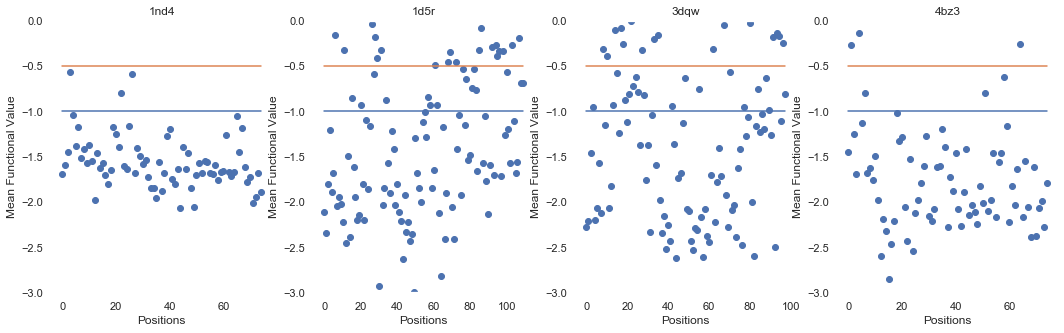

In [98]:
#Plot functional mean values for predicted positions
fig = plt.figure(figsize=(18,5))
for i, protein in enumerate(proteins2):
    mean = all_negatives[protein].mean()
    values = [mean[pos] for pos in best_predictions[protein]]
    n = len(values)
    ax = fig.add_subplot(1, 4, i+1)
    ax.set_facecolor('xkcd:white')
    ax.set_ylim([-3,0])
    plt.plot([i for i in range(n)], values, 'bo')
    plt.plot([i for i in range(n)], [-1 for i in range(n)])
    plt.plot([i for i in range(n)], [-0.5 for i in range(n)])
    plt.xlabel('Positions')
    plt.ylabel('Mean Functional Value')
    plt.title(protein)
plt.show()

In [99]:
# Distribution of predicted positions
df = pd.DataFrame(index=proteins2, columns=['< -1', '-1 : -0.5', '-0.5 : 0'])
for protein in proteins2:
    mean = all_negatives[protein].mean()
    values = [mean[pos] for pos in best_predictions[protein]]
    
    df.at[protein, '< -1'] = str(round(100*len([i for i in values if i < -1])/len(values), 1))+'%'
    df.at[protein, '-1 : -0.5'] = str(round(100*len([i for i in values if i > -1 and i < -0.5])/len(values), 1))+'%'
    df.at[protein, '-0.5 : 0'] = str(round(100*len([i for i in values if i > -0.5])/len(values), 1))+'%'
    
display(df)

,< -1,-1 : -0.5,-0.5 : 0
1nd4,96.0%,4.0%,0.0%
1d5r,69.1%,13.6%,17.3%
3dqw,65.3%,18.4%,16.3%
4bz3,92.0%,4.0%,4.0%


Es curioso que haya muchas posiciones muy parecidas a cero que predecimos, tal vez sean posiciones donde una mutación es muy mala, y otras son buenas, y al hacer las buenas cero, parece que tiene poco cambio funcional. Creo que eso ya es demasiado específico, y podemos concentrarnos en las predicciones que tenemos hasta este momento, que son bastante buenas. 

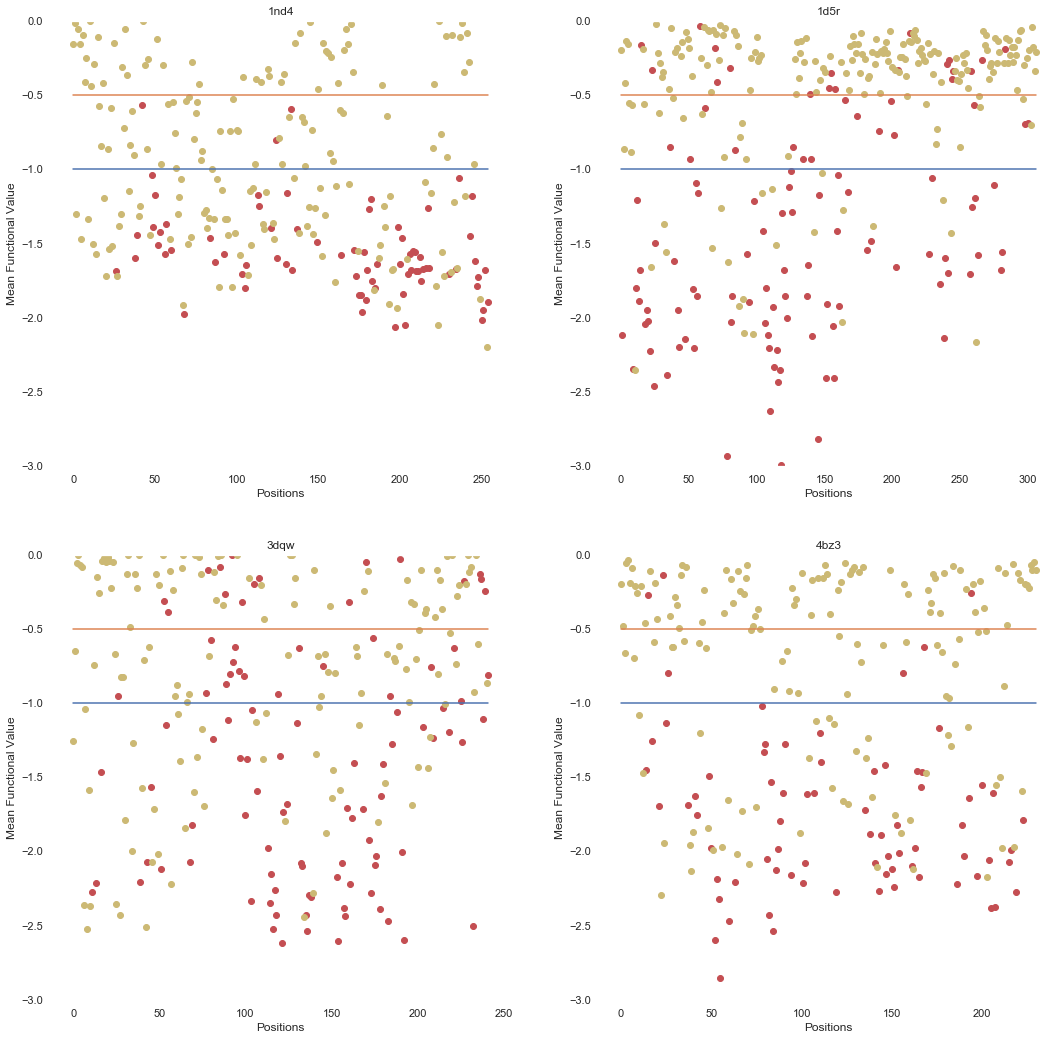

In [100]:
fig = plt.figure(figsize=(18,18))
for x, protein in enumerate(proteins2):
    mean = all_negatives[protein].mean()
    positions = all_negatives[protein].columns
    n = len(positions)
    values = [1]*n
    other_values = [1]*n
    predictions = best_predictions[protein]
    for i,pos in enumerate(positions):
        if pos in predictions:
            values[i] = mean[pos]
        else:
            other_values[i] = mean[pos]

    ax = fig.add_subplot(2, 2, x+1)
    ax.set_facecolor('xkcd:white')
    ax.set_ylim([-3,0])
    plt.plot([i for i in range(n)], values, 'ro')
    plt.plot([i for i in range(n)], other_values, 'yo')
    plt.plot([i for i in range(n)], [-1 for i in range(n)])
    plt.plot([i for i in range(n)], [-0.5 for i in range(n)])
    plt.xlabel('Positions')
    plt.ylabel('Mean Functional Value')
    plt.title(protein)
plt.show()

In [102]:
# Check if bottom percentage of proteins gives better predictions than selecting by standard deviations
for cutoff in [1, 1.5]:
    for mincount in [1,2,3,4]:
        for percentage in [0.3, 0.4]:
            extreme_values = pd.DataFrame(index=proteins2, columns=['True Positives', 'False Positives', 
                                                                   'Coverage', 'Accuracy'])
            for protein in proteins2:
                functional_df = all_negatives[protein]
                functional_mean = functional_df.mean()
                positions = list(functional_df.columns)

                pairs = [(functional_mean[pos], pos) for pos in positions] # list with value and position
                pairs.sort(key = lambda x:x[0]) # sort by functional values
                n = int(len(positions)*percentage)
                functional_extremes = set([pair[1] for pair in pairs[:n]])

                network_extremes_list = []
                for measure in measures: 
                    threshold = 3.8 if measure == 'distance' else 9.0
                    network_df = Standardize(protein, threshold, measure)
                    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
                    network_extremes_list.extend(extremes)

                counter = Counter(network_extremes_list)
                positions = list(set(network_extremes_list))
                network_extremes = set([pos for pos in positions if counter[pos] >= mincount])

                how_many = len(network_extremes.intersection(functional_extremes))

                extreme_values.at[protein, 'True Positives'] = how_many
                if len(functional_extremes) > 0:
                    extreme_values.at[protein,'Coverage']=str(round(100*how_many/len(functional_extremes),1))+'%' 
                extreme_values.at[protein, 'False Positives'] = len(network_extremes) - how_many 
                if len(network_extremes) > 0:
                    extreme_values.at[protein, 'Accuracy'] = str(round(100*how_many/len(network_extremes), 1))+'%'
        print(f'std network = {cutoff}, min counts = {mincount}, bottom {100*percentage}%')
        display(extreme_values)

std network = 1, min counts = 1, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,94,83,92.2%,53.1%
1d5r,113,104,92.6%,52.1%
3dqw,86,97,89.6%,47.0%
4bz3,92,77,100.0%,54.4%


std network = 1, min counts = 2, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,85,44,83.3%,65.9%
1d5r,111,55,91.0%,66.9%
3dqw,76,75,79.2%,50.3%
4bz3,89,46,96.7%,65.9%


std network = 1, min counts = 3, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,70,33,68.6%,68.0%
1d5r,104,42,85.2%,71.2%
3dqw,69,61,71.9%,53.1%
4bz3,83,31,90.2%,72.8%


std network = 1, min counts = 4, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,59,16,57.8%,78.7%
1d5r,87,23,71.3%,79.1%
3dqw,58,40,60.4%,59.2%
4bz3,61,14,66.3%,81.3%


std network = 1.5, min counts = 1, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,87,54,85.3%,61.7%
1d5r,112,93,91.8%,54.6%
3dqw,76,74,79.2%,50.7%
4bz3,87,46,94.6%,65.4%


std network = 1.5, min counts = 2, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,69,24,67.6%,74.2%
1d5r,101,35,82.8%,74.3%
3dqw,66,40,68.8%,62.3%
4bz3,79,29,85.9%,73.1%


std network = 1.5, min counts = 3, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,56,14,54.9%,80.0%
1d5r,85,23,69.7%,78.7%
3dqw,56,31,58.3%,64.4%
4bz3,66,21,71.7%,75.9%


std network = 1.5, min counts = 4, bottom 40.0%


,True Positives,False Positives,Coverage,Accuracy
1nd4,37,5,36.3%,88.1%
1d5r,68,13,55.7%,84.0%
3dqw,37,14,38.5%,72.5%
4bz3,49,5,53.3%,90.7%


Mientras más grande sea el porcentaje, mejores son las predicciones. En particular, porcentajes grandes y exigir que pase el cutoff en al menos 4 medidas da muy buena precisión. Por ejemplo, con 40%, 4 medidas y 1.5 network std, llegamos a valores de precisión [88%, 84%, 72%, 90%], con cobertura entre 36% y 55%, mientras que con 45% llegamos a [93%, 89%, 78%, 96%] de precisión, con cobertura entre 34% y 52%. Por otro lado, tenemos buena cobertura aún con porcentajes más bajos, para 30%, con 1 para network std, los que pasan el threshold para al menos una medida dan cobertura de [96%, 96%, 91%, 100%], aunque la precisión promedio es de 40%. Y en general, podemos alcanzar coberturas muy buenas para porcentajes más bajos, aunque con poca precisión. Pasar el threshold para dos y tres medidas da valores más balanceados de precisión y cobertura. 

En general, creo que se ven mejor distribuidos tomando porcentajes que con las desviaciones, es decir, los valores de precisión y cobertura son más parecidos, que creo que ayuda a hacer las conclusiones más formales, pero la diferencia no es tanta. Además, creo que tiene más sentido poder escoger qué tantas posiciones queremos predecir.  

In [ ]:
#data_path = "/Users/macbook/Documents/perturbation-networks/dms_data"
#for protein in proteins:
#    all_positives[protein].to_csv(os.path.join(data_path, f'all_positives_{protein}.csv'))

In [103]:
len(functional_data['1be9'].columns)

83

- Pasar todo en limpio
    - Usar 5.0 como threshold en lugar de 9.0
    - Repetir análisis con ganancia de función
    - Subir archivos de datos funcionales normales, all_negatives, all_positives
    - Incluir a 1be9 
    - Escribir función para los true positives y eso 
- Preguntas
    - ¿Desviaciones o porcentajes? 
    - 